# Population Estimates Data Exploration

Inital thoughts:

Population estimate table: can fill missing values in 0-4 year olds by taking the sum of 1-4, 5-9, and 10-14 from the estimate of 0-14 - this gives us the number of 0 year olds, which can be added to the 1-4 yos.
Migration table: Can fill missing values in net migration by subtracting emigrants from immigrants. In earlier years the totals aren't calculated, but can be derived from summing the completed ages

Population (https://data.cso.ie/table/PEA01) and Migration (https://data.cso.ie/table/PEA03) datasets were retrieved from data.cso.ie at 10AM on the 6th of October 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import binom, poisson, bootstrap, uniform
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pathlib import Path
import itertools
import random
import warnings

warnings.filterwarnings('ignore')

charts_folder = Path('charts/')
if not charts_folder.exists():
    charts_folder.mkdir()
    
data_folder = Path('data/')
if not data_folder.exists():
    data_folder.mkdir()
    
sns.set(style="darkgrid", font='serif', rc={'lines.linewidth': 0.7})    

Our first dataset is the population estimates in April from 1950 to 2023.

We first load the dataframe from csv and change the column names to snake_case by converting to lowercase and replacing spaces with underscores, this is done as a stylistic choice so that the column names are in a consistent case with our variable names.

We will apply the same column transformation to multiple csvs throughout the notebook, so we create a function that can be reused later. 

Additionally, we have set the seaborn style to "darkgrid", which is a similar to default themes used in graphics libraries such as R's ggplot2, and conforms to style directives outlined by Tufte (p. 112, 116), namely that the grid background should be a muted grey so as to not be distracting, and that gridlines should be use minimal ink. In this case, gridlines are given as negative space, so do not use ink at all. He also argues in favour of using a font family with serifs in order to create more "friendly" graphics, which we can also set globally here.

Finally, we set the default linewidth to slightly thinner than seaborn's default. Again, Tufte argues that thinner lines, and therefore less data ink, result in more aesthetically pleasing graphics (p. 184-185).

In [2]:
def read_csv_and_fix_names(filename):
    df = pd.read_csv(filename)
    df = df.rename(columns={x: x.lower().replace(' ', '_') for x in df.columns})
    return df

population_df = read_csv_and_fix_names(data_folder / 'population_estimates.csv')
print(population_df.dtypes)
print(population_df.shape)
population_df.head(15)

statistic           object
statistic_label     object
tlist(a1)            int64
year                 int64
c02076v02508        object
age_group           object
c02199v02655        object
sex                 object
unit                object
value              float64
dtype: object
(5994, 10)


,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value
0,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,-,Both sexes,Thousand,61.1
1,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,1,Male,Thousand,31.4
2,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,2,Female,Thousand,29.7
3,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,-,Both sexes,Thousand,NaN
4,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,1,Male,Thousand,NaN
5,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,2,Female,Thousand,NaN
6,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,-,Both sexes,Thousand,851.2
7,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,1,Male,Thousand,434.6
8,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,2,Female,Thousand,416.6
9,PEA01,Population Estimates (Persons in April),1950,1950,225,1 - 4 years,-,Both sexes,Thousand,249.1


We can see that we have missing values the "value" column, however, this only occurs in the 0-4 years age groups, not every year, and only in years until 1995

In [3]:
population_df.loc[pd.isna(population_df.value)]['age_group'].value_counts()

age_group
0 - 4 years    114
Name: count, dtype: int64

In [4]:
population_df.loc[(population_df['age_group'] == "0 - 4 years") & (pd.isna(population_df['value']))].head()

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value
3,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,-,Both sexes,Thousand,NaN
4,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,1,Male,Thousand,NaN
5,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,2,Female,Thousand,NaN
165,PEA01,Population Estimates (Persons in April),1952,1952,205,0 - 4 years,-,Both sexes,Thousand,NaN
166,PEA01,Population Estimates (Persons in April),1952,1952,205,0 - 4 years,1,Male,Thousand,NaN


In [5]:
population_df.loc[(population_df['age_group']=="0 - 4 years") & (pd.isna(population_df['value']))].tail()

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value
3568,PEA01,Population Estimates (Persons in April),1994,1994,205,0 - 4 years,1,Male,Thousand,NaN
3569,PEA01,Population Estimates (Persons in April),1994,1994,205,0 - 4 years,2,Female,Thousand,NaN
3648,PEA01,Population Estimates (Persons in April),1995,1995,205,0 - 4 years,-,Both sexes,Thousand,NaN
3649,PEA01,Population Estimates (Persons in April),1995,1995,205,0 - 4 years,1,Male,Thousand,NaN
3650,PEA01,Population Estimates (Persons in April),1995,1995,205,0 - 4 years,2,Female,Thousand,NaN


## Missing Data Treatment

We can try to fill in the missing 0-4 year olds using a combination of other columns;
We have "Under 1 year" as a value within age_group, so we should be able to add this to the "1 - 4 years" value to get "0 - 4 years".
We can check if this works by comparing against the completed entries post-1995.

In [6]:
pivoted_population_df = population_df.pivot(columns='age_group', index=['year', 'sex'], values='value')
pivoted_population_df.head()

age_group        0 - 14 years  0 - 4 years  1 - 4 years  10 - 14 years  \
year sex                                                                 
1950 Both sexes         851.2          NaN        249.1          262.1   
     Female             416.6          NaN        121.6          128.7   
     Male               434.6          NaN        127.5          133.4   
1951 Both sexes         854.8        312.9        249.3          260.9   
     Female             418.4        152.6        121.7          128.2   

age_group        15 - 19 years  15 - 24 years  15 years and over  \
year sex                                                           
1950 Both sexes          244.0          452.6             2117.8   
     Female              117.4          217.7             1042.4   
     Male                126.6          234.9             1075.4   
1951 Both sexes          241.2          443.4             2105.8   
     Female              115.4          212.2             1035.6   

age_group        20 - 24 years  25 - 29 years  25 - 44 years  ...  \
year sex                                                      ...   
1950 Both sexes          208.6          201.1          773.6  ...   
     Female              100.3          100.2          380.2  ...   
     Male                108.3          100.9          393.4  ...   
1951 Both sexes          202.2          198.4          771.2  ...   
     Female               96.8           98.8          378.9  ...   

age_group        55 - 59 years  60 - 64 years  65 - 69 years  \
year sex                                                       
1950 Both sexes          130.4          121.9          109.3   
     Female               64.6           60.6           54.1   
     Male                 65.8           61.3           55.2   
1951 Both sexes          128.8          122.1          107.5   
     Female               63.8           60.7           53.4   

age_group        65 years and over  70 - 74 years  75 - 79 years  \
year sex                                                           
1950 Both sexes              317.1          100.4           64.0   
     Female                  161.3           50.9           32.6   
     Male                    155.8           49.5           31.4   
1951 Both sexes              316.4          100.1           64.6   
     Female                  161.4           51.0           32.9   

age_group        80 - 84 years  85 years and over  All ages  Under 1 year  
year sex                                                                   
1950 Both sexes           30.1               13.3    2969.0          61.1  
     Female               15.9                7.8    1459.0          29.7  
     Male                 14.2                5.5    1510.0          31.4  
1951 Both sexes           30.9               13.3    2960.6          63.6  
     Female               16.2                7.8    1454.0          30.9  

[5 rows x 27 columns]

In [7]:
pivoted_population_df['candidate_imputation'] = pivoted_population_df['Under 1 year'] + pivoted_population_df['1 - 4 years']
nonnull_rows = pivoted_population_df.loc[~pd.isna(pivoted_population_df['0 - 4 years'])]
print((nonnull_rows['0 - 4 years'] == nonnull_rows['candidate_imputation']).value_counts())
print(len(nonnull_rows))

True     61
False    47
Name: count, dtype: int64
108


We see however that this doesn't work, as our candidate value does not equal the reported value in 47/108 cases.

In [8]:
discrepancy_rows = nonnull_rows[nonnull_rows['0 - 4 years'] != nonnull_rows['candidate_imputation']].copy()
discrepancy_rows['difference'] = (discrepancy_rows['0 - 4 years'] - discrepancy_rows['candidate_imputation']).map('{:,.2f}'.format)
discrepancy_rows[['1 - 4 years', 'Under 1 year', '0 - 4 years', 'candidate_imputation', 'difference']]

age_group        1 - 4 years  Under 1 year  0 - 4 years  candidate_imputation  \
year sex                                                                        
1951 Both sexes        249.3          63.6        312.9                 312.9   
     Male              127.6          32.6        160.0                 160.2   
1961 Female            116.7          30.6        147.4                 147.3   
1966 Both sexes        252.3          63.6        315.9                 315.9   
1971 Both sexes        250.8          64.9        315.6                 315.7   
     Male              128.6          33.3        161.8                 161.9   
1979 Female            132.7          35.2        167.8                 167.9   
     Male              139.5          36.2        175.6                 175.7   
1981 Female            136.3          35.7        171.9                 172.0   
1986 Both sexes        262.9          61.2        324.1                 324.1   
1991 Female            107.5          25.7        133.8                 133.2   
1997 Female             96.9          24.4        121.3                 121.3   
1998 Both sexes        201.1          52.6        253.6                 253.7   
1999 Both sexes        206.4          53.3        259.8                 259.7   
     Female             99.9          25.9        125.8                 125.8   
     Male              106.5          27.4        134.0                 133.9   
2000 Both sexes        212.5          53.6        266.2                 266.1   
2001 Female            106.1          26.7        133.0                 132.8   
2006 Both sexes        241.3          61.1        302.3                 302.4   
     Female            117.9          29.8        147.7                 147.7   
     Male              123.4          31.3        154.7                 154.7   
2007 Female            118.8          32.2        151.1                 151.0   
2008 Male              129.1          36.9        165.9                 166.0   
2009 Both sexes        261.7          73.6        335.2                 335.3   
     Male              133.8          37.7        171.4                 171.5   
2010 Both sexes        272.0          74.9        347.0                 346.9   
     Female            133.0          36.5        169.4                 169.5   
2011 Both sexes        283.6          72.5        356.0                 356.1   
2012 Female            280.7          35.4        175.4                 316.1   
     Male              145.5          37.0        182.7                 182.5   
2013 Female            277.3          33.5        173.1                 310.8   
     Male              144.9          35.0        180.0                 179.9   
2014 Both sexes        278.4          66.9        345.4                 345.3   
     Female            278.7          32.6        169.3                 311.3   
     Male              141.7          34.0        176.0                 175.7   
2015 Both sexes        273.8          64.2        337.9                 338.0   
     Female            279.7          31.4        165.6                 311.1   
     Male              139.6          33.0        172.4                 172.6   
2016 Female            281.9          30.4        161.7                 312.3   
     Male              137.8          32.0        169.7                 169.8   
2017 Male              133.7          32.4        166.2                 166.1   
2018 Male              132.2          31.7        163.9                 163.9   
2020 Female            121.6          28.3        150.0                 149.9   
     Male              128.9          29.8        158.8                 158.7   
2021 Female            119.3          27.4        146.8                 146.7   
2022 Both sexes        238.2          57.7        295.8                 295.9   
     Male              122.0          29.5        151.6                 151.5   

age_group       difference  
y

Some of these discrepancises appear to arise from floating point arithmetic, such as "Both sexes" in 1951, where the difference is <<0.1.

A lot of these may be rounding errors arising from aggregation from a lower level, as many values are off by small but nonnegligable amounts (0.1-0.6).

However these discrepancies also draw our attention to some strange values - for example, in 2015, the number of Female 1-4 year olds was greater than the value for both sexes, which doesn't make much sense.

In [9]:
pivoted_population_df[['1 - 4 years', 'Under 1 year', '0 - 4 years', '0 - 14 years', 'candidate_imputation']].loc[2015]

age_group,1 - 4 years,Under 1 year,0 - 4 years,0 - 14 years,candidate_imputation
sex,,,,,
Both sexes,273.8,64.2,337.9,1001.7,338.0
Female,279.7,31.4,165.6,490.0,311.1
Male,139.6,33.0,172.4,511.8,172.6


We can look at this in the original data just to confirm that we don't have a misspecified pivot or other programming error. 

I thought it might be possible that the unit in this case was 'Hundred' instead of "Thousand" and that's what was throwing things off, but that doesn't seem to be the case, and this may be a genuine reporting error.

In [10]:
population_df[(population_df['year'] == 2015) & (population_df['age_group'] == '1 - 4 years')]

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value
5274,PEA01,Population Estimates (Persons in April),2015,2015,225,1 - 4 years,-,Both sexes,Thousand,273.8
5275,PEA01,Population Estimates (Persons in April),2015,2015,225,1 - 4 years,1,Male,Thousand,139.6
5276,PEA01,Population Estimates (Persons in April),2015,2015,225,1 - 4 years,2,Female,Thousand,279.7


These large discrepancies (>1000 people) only appear to occur in Females between 2012 and 2016 - the years between the 2011 and 2016 census.

There are multiple possibilities for what's going on:

- The number of female 1-4 year olds is overreported (this seems to be the most likely as, in 2015, it is so much higher than the values for 0-4 years and is over
- The number for "Both sexes" is underreported, and should be taken as the sum of the reported Male and Female figures
- Neither figure is correct

The only one of these years that contained a census was 2016, so we can use this as an alternative source to check. The age breakdown for the 2016 census is found at - https://data.cso.ie/table/E3018 (retrieved at 2pm on the 6th of October 2023)

## Comparison to Census 2016

In [11]:
census_2016_age_df  = read_csv_and_fix_names(data_folder / 'census_2016_population_per_age.csv')
census_2016_age_df = census_2016_age_df.loc[(census_2016_age_df['censusyear'] == 2016)]
census_2016_age_df.head()

,statistic,statistic_label,tlist(a1),censusyear,c02779v03348,electoral_division,unit,value
3442,E3018C01,Persons of all ages,2016,2016,-,State,Number,4761865
3443,E3018C01,Persons of all ages,2016,2016,01001,"001 Carlow Urban, Co. Carlow",Number,4560
3444,E3018C01,Persons of all ages,2016,2016,01002,"002 Graigue Urban, Co. Carlow",Number,1405
3445,E3018C01,Persons of all ages,2016,2016,01012,"012 Ballinacarrig (Part Urban), Co. Carlow",Number,1025
3446,E3018C01,Persons of all ages,2016,2016,01019,"019 Carlow Rural (Part Urban), Co Carlow",Number,14546


This data is split by electoral division, but for our verification we are primarily concerned with the total, which is given by the electoral division value of 'State'

In [12]:
census_2016_age_df.loc[(census_2016_age_df['electoral_division'] == 'State')]

,statistic,statistic_label,tlist(a1),censusyear,c02779v03348,electoral_division,unit,value
3442,E3018C01,Persons of all ages,2016,2016,-,State,Number,4761865
10326,E3018C02,Persons aged 0-4 years,2016,2016,-,State,Number,331515
17210,E3018C03,Persons aged 5-12 years,2016,2016,-,State,Number,548693
24094,E3018C04,Persons aged 13-18 years,2016,2016,-,State,Number,371588
30978,E3018C05,Persons aged 19-24 years,2016,2016,-,State,Number,331208
37862,E3018C06,Persons aged 25-44 years,2016,2016,-,State,Number,1406291
44746,E3018C07,Persons aged 45-64 years,2016,2016,-,State,Number,1135003
51630,E3018C08,Persons aged 65-69 years,2016,2016,-,State,Number,211236
58514,E3018C09,Persons aged 70 years and over,2016,2016,-,State,Number,426331


In [13]:
census_2016_age_df.loc[(census_2016_age_df['electoral_division'] == 'State') &
    (census_2016_age_df['statistic_label'] != 'Persons of all ages') 
]['value'].sum()

4761865

We confirm that the total value for persons of all ages is equal to the sum of the age subdivisions, so the data is internally consistent in this sense.

We notice however, that the age divisions are different in this dataset compared to the estimate dataset - we do not have a 1-4 years category, which is the variable where our issue resides. We will therefore have to sum the variables which cover the 0-4 age range in our original dataset, and compare that total to the 0-4 total in the census dataset.

We can also compare the 0-4 range itself from the original dataset.

We will look at the totals we get from Both Sexes, then by Males + Females, using a variable cover of:
"Under 1 year" + "1 - 4 years" = "0 - 4 years". In each case we need to multiply the figures from the original dataset by 1000 as they are expressed in thousands of people.

In [14]:
pivoted_2016 = pivoted_population_df.loc[2016].copy()

pivoted_2016['0 - 4 years'] = pivoted_2016['0 - 4 years']*1000
pivoted_2016['0 - 4 summed'] = (pivoted_2016['Under 1 year'] + pivoted_2016['1 - 4 years'])*1000
pivoted_2016['0 - 4 census'] = census_2016_age_df.loc[
    (census_2016_age_df['electoral_division'] == 'State') & (census_2016_age_df['statistic_label'] == 'Persons aged 0-4 years')
    ]['value'].iat[0]

In [15]:
pivoted_2016[[
    '0 - 4 years', 
    '0 - 4 summed', 
    '0 - 4 census']]

age_group,0 - 4 years,0 - 4 summed,0 - 4 census
sex,,,
Both sexes,331400.0,331400.0,331515
Female,161700.0,312300.0,331515
Male,169700.0,169800.0,331515


We can see that the Both Sexes figures for both the 0-4 years and our 0-4 summed variable agree with the census figures (a difference of 115 people), whereas the Female + Male figures for our 0-4 summed variable would give us a total of over 480k, which is far greater than the census figure, leading us to conclude that the 1-4 years data for Females has likely been reported erroneously.

## Error Correction & Imputation

As these values are errorneous, we can treat them as missing values and impute them. As the, Female figures could be thought of as a univariate time series, we could use interpolation or other time-series-appropriate imputation methods, such as those outlined by Moritz et al 2015. However, due the structure of this particular dataset, we can use the opposite procedure to how we inferred the missing 1-4 years data earlier; by subtracting the under 1 year value from the 0-4 year value. We can then use this resulting column to once again derive a candidate imputation for the 0-4 years variable. 

We can see that our second candidate imputation does not have the same odd values as before.

In [16]:
def impute_missing_1_4_yos(row):
    if row.name[1] == 'Female' and  2012 <= row.name[0] <= 2016:
        return row['0 - 4 years'] - row['Under 1 year'] 
    else:
        return row['1 - 4 years']

pivoted_population_df['fixed_1_4'] = pivoted_population_df.apply(impute_missing_1_4_yos, axis=1)
pivoted_population_df['candidate_imputation_2'] = pivoted_population_df['Under 1 year'] + pivoted_population_df['fixed_1_4']
pivoted_population_df[['0 - 4 years', '1 - 4 years', 'fixed_1_4', 'candidate_imputation', 'candidate_imputation_2']]\
    [(pivoted_population_df.index.get_level_values('year') >= 2012) & 
    (pivoted_population_df.index.get_level_values('year') <= 2016)]

age_group        0 - 4 years  1 - 4 years  fixed_1_4  candidate_imputation  \
year sex                                                                     
2012 Both sexes        358.2        285.5      285.5                 358.2   
     Female            175.4        280.7      140.0                 316.1   
     Male              182.7        145.5      145.5                 182.5   
2013 Both sexes        353.0        284.4      284.4                 353.0   
     Female            173.1        277.3      139.6                 310.8   
     Male              180.0        144.9      144.9                 179.9   
2014 Both sexes        345.4        278.4      278.4                 345.3   
     Female            169.3        278.7      136.7                 311.3   
     Male              176.0        141.7      141.7                 175.7   
2015 Both sexes        337.9        273.8      273.8                 338.0   
     Female            165.6        279.7      134.2                 311.1   
     Male              172.4        139.6      139.6                 172.6   
2016 Both sexes        331.4        269.2      269.2                 331.4   
     Female            161.7        281.9      131.3                 312.3   
     Male              169.7        137.8      137.8                 169.8   

age_group        candidate_imputation_2  
year sex                                 
2012 Both sexes                   358.2  
     Female                       175.4  
     Male                         182.5  
2013 Both sexes                   353.0  
     Female                       173.1  
     Male                         179.9  
2014 Both sexes                   345.3  
     Female                       169.3  
     Male                         175.7  
2015 Both sexes                   338.0  
     Female                       165.6  
     Male                         172.6  
2016 Both sexes                   331.4  
     Female                       161.7  
     Male                         169.8

_Note: I contacted the CSO about these data inconsistencies, and they confirmed that there was a coding issue from when the table was created, causing the 15-24 years totals to overwrite the 1-4 years totals. They informed me on 10/10/23 that they will begin work to update the source data._

In [17]:
pivoted_population_df[['1 - 4 years', '15 - 24 years']]\
    [(pivoted_population_df.index.get_level_values('year') >= 2012) & 
    (pivoted_population_df.index.get_level_values('year') <= 2016)]

age_group        1 - 4 years  15 - 24 years
year sex                                   
2012 Both sexes        285.5          566.6
     Female            280.7          280.7
     Male              145.5          285.8
2013 Both sexes        284.4          563.3
     Female            277.3          277.3
     Male              144.9          286.0
2014 Both sexes        278.4          567.2
     Female            278.7          278.7
     Male              141.7          288.5
2015 Both sexes        273.8          571.6
     Female            279.7          279.7
     Male              139.6          291.9
2016 Both sexes        269.2          574.7
     Female            281.9          281.9
     Male              137.8          292.8

In [18]:
cleaned_pivoted_df = pivoted_population_df.copy()
cleaned_pivoted_df['1 - 4 years'] = cleaned_pivoted_df['fixed_1_4']
cleaned_pivoted_df['0 - 4 years'] = cleaned_pivoted_df['candidate_imputation_2']

cleaned_pivoted_df = cleaned_pivoted_df.drop(['fixed_1_4', 'candidate_imputation', 'candidate_imputation_2'], axis=1)
cleaned_pivoted_df.head()

age_group        0 - 14 years  0 - 4 years  1 - 4 years  10 - 14 years  \
year sex                                                                 
1950 Both sexes         851.2        310.2        249.1          262.1   
     Female             416.6        151.3        121.6          128.7   
     Male               434.6        158.9        127.5          133.4   
1951 Both sexes         854.8        312.9        249.3          260.9   
     Female             418.4        152.6        121.7          128.2   

age_group        15 - 19 years  15 - 24 years  15 years and over  \
year sex                                                           
1950 Both sexes          244.0          452.6             2117.8   
     Female              117.4          217.7             1042.4   
     Male                126.6          234.9             1075.4   
1951 Both sexes          241.2          443.4             2105.8   
     Female              115.4          212.2             1035.6   

age_group        20 - 24 years  25 - 29 years  25 - 44 years  ...  \
year sex                                                      ...   
1950 Both sexes          208.6          201.1          773.6  ...   
     Female              100.3          100.2          380.2  ...   
     Male                108.3          100.9          393.4  ...   
1951 Both sexes          202.2          198.4          771.2  ...   
     Female               96.8           98.8          378.9  ...   

age_group        55 - 59 years  60 - 64 years  65 - 69 years  \
year sex                                                       
1950 Both sexes          130.4          121.9          109.3   
     Female               64.6           60.6           54.1   
     Male                 65.8           61.3           55.2   
1951 Both sexes          128.8          122.1          107.5   
     Female               63.8           60.7           53.4   

age_group        65 years and over  70 - 74 years  75 - 79 years  \
year sex                                                           
1950 Both sexes              317.1          100.4           64.0   
     Female                  161.3           50.9           32.6   
     Male                    155.8           49.5           31.4   
1951 Both sexes              316.4          100.1           64.6   
     Female                  161.4           51.0           32.9   

age_group        80 - 84 years  85 years and over  All ages  Under 1 year  
year sex                                                                   
1950 Both sexes           30.1               13.3    2969.0          61.1  
     Female               15.9                7.8    1459.0          29.7  
     Male                 14.2                5.5    1510.0          31.4  
1951 Both sexes           30.9               13.3    2960.6          63.6  
     Female               16.2                7.8    1454.0          30.9  

[5 rows x 27 columns]

We can now take the MultiIndex (year/sex) into the dataframe with reset_index(), and use the inverse function of pivot; melt, to get our data into the same format as our original data.

With our data unpivoted, we can now join it back to the original dataset using (year, age_group, sex) as a composite key, and obtain a new "value" column with our imputations and edits.

In [19]:
molten_cleaned_df = cleaned_pivoted_df.reset_index().melt(id_vars=['year', 'sex'])
molten_cleaned_df.head()

,year,sex,age_group,value
0,1950,Both sexes,0 - 14 years,851.2
1,1950,Female,0 - 14 years,416.6
2,1950,Male,0 - 14 years,434.6
3,1951,Both sexes,0 - 14 years,854.8
4,1951,Female,0 - 14 years,418.4


In [20]:
cleaned_population_df = population_df[[x for x in population_df.columns if x != 'value']]\
    .merge(molten_cleaned_df, on=['year', 'sex', 'age_group'])
cleaned_population_df.head(15)

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value
0,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,-,Both sexes,Thousand,61.1
1,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,1,Male,Thousand,31.4
2,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,2,Female,Thousand,29.7
3,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,-,Both sexes,Thousand,310.2
4,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,1,Male,Thousand,158.9
5,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,2,Female,Thousand,151.3
6,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,-,Both sexes,Thousand,851.2
7,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,1,Male,Thousand,434.6
8,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,2,Female,Thousand,416.6
9,PEA01,Population Estimates (Persons in April),1950,1950,225,1 - 4 years,-,Both sexes,Thousand,249.1


We can now confirm that we have no missing values.

In [21]:
cleaned_population_df.loc[pd.isna(cleaned_population_df.value)]

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value


In [22]:
cleaned_population_df.to_csv(data_folder / "cleaned_population_estimates.csv", index=False)

Wickham (2011) argues that when data is collected at multiple levels, as is the case here with both the individual figures per sex and their sum being stored on separate rows, the data should be split into tables containing individual observational units. 

We can do this easily by grouping on the condition that sex = 'Both sexes', and then unpacking the groupby object, making sure to discard the group labels from each tuple that the groupby yields. Additionally, we know ahead of time the order that the groups will be unpacked because the pandas groupby method has an argument "sort" (defaulting to True) which sorts the group keys, and in python booleans are considered numeric and equivalent to 0 and 1, therefore the False brance will be the first value of the groupby.

In [23]:
(_, sexes_df), (_, both_sexes_df) = cleaned_population_df.groupby(cleaned_population_df['sex'] == 'Both sexes')

In [24]:
sexes_df.head()

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value
1,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,1,Male,Thousand,31.4
2,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,2,Female,Thousand,29.7
4,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,1,Male,Thousand,158.9
5,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,2,Female,Thousand,151.3
7,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,1,Male,Thousand,434.6


In [25]:
both_sexes_df.head()

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,value
0,PEA01,Population Estimates (Persons in April),1950,1950,200,Under 1 year,-,Both sexes,Thousand,61.1
3,PEA01,Population Estimates (Persons in April),1950,1950,205,0 - 4 years,-,Both sexes,Thousand,310.2
6,PEA01,Population Estimates (Persons in April),1950,1950,215,0 - 14 years,-,Both sexes,Thousand,851.2
9,PEA01,Population Estimates (Persons in April),1950,1950,225,1 - 4 years,-,Both sexes,Thousand,249.1
12,PEA01,Population Estimates (Persons in April),1950,1950,245,5 - 9 years,-,Both sexes,Thousand,278.9


## Exploration by visualisation

We would like to get a better sense of how population has changed over time by statistically summarising the data, and also by plotting it. 


Initially, we will consider the Both sexes and All ages case, as this will give us an idea of high level trends in population over time. We can see that, across all years, the mean population count was about 3.6M, with a standard deviation of 718K. We can also immediately see that the data is right-skewed, as the mean is greater than the median, and the upper tail of the variable's boxplot is longer.

In [26]:
all_ages_df = both_sexes_df[both_sexes_df['age_group'] == 'All ages'].copy()
print(all_ages_df[['year', 'value']].describe())

              year        value
count    74.000000    74.000000
mean   1986.500000  3641.322973
std      21.505813   718.940701
min    1950.000000  2818.300000
25%    1968.250000  2954.825000
50%    1986.500000  3527.350000
75%    2004.750000  4111.650000
max    2023.000000  5281.600000


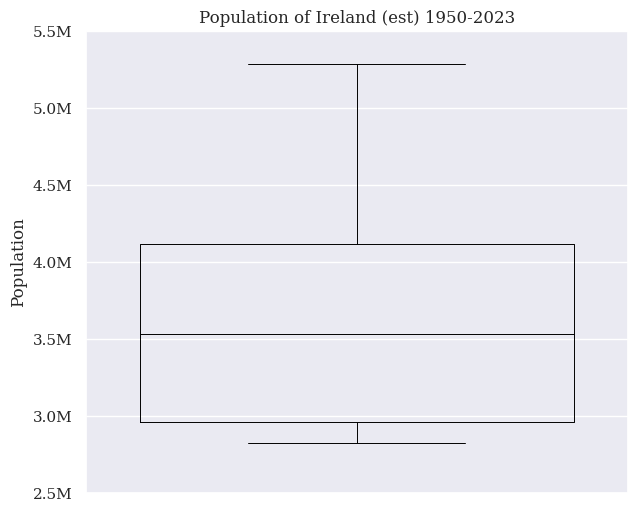

In [27]:
fig, ax = plt.subplots(figsize=(7, 6)) 
p = sns.boxplot(all_ages_df['value'], fill=None, color='black')
p.set(title='Population of Ireland (est) 1950-2023', ylabel='Population')
ylabs = ['{:,.1f}M'.format(x) if x > 0.1 else 0 for x in p.get_yticks()/1000]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs);
fig.savefig(charts_folder / 'population_boxplot.png')

### Population Overview

Our year and population variables are both continuous, and they form a univariate time series, so a line chart is a natural choice of visualisation to highlight the time-dependencies between each successive data point.

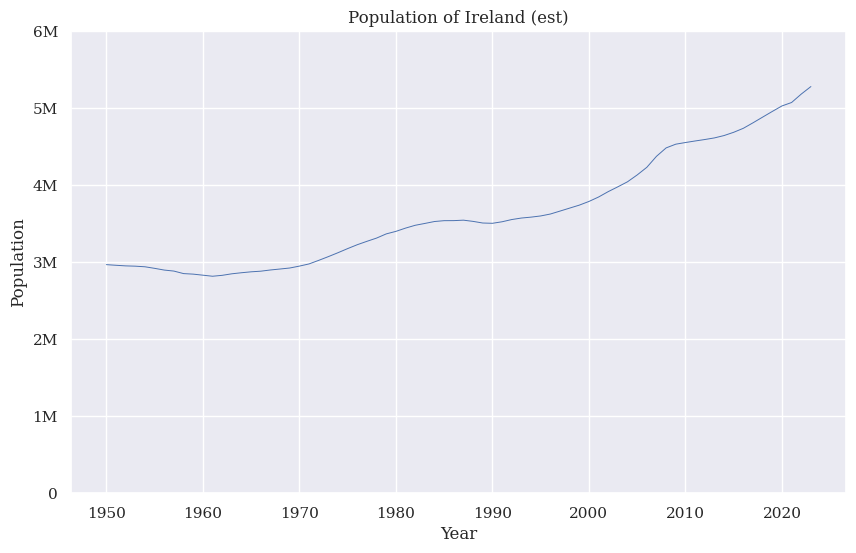

In [28]:
all_ages_df['value'] = all_ages_df['value']*1000
fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.lineplot(all_ages_df, x='year', y='value')
p.set(title='Population of Ireland (est)', xlabel='Year', ylabel='Population', ylim=(0,None))
ylabs = ['{:,.0f}M'.format(x) if x > 0.1 else 0 for x in p.get_yticks()/1000000]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs);

fig.savefig(charts_folder / 'population_over_time.png')

We see that the overall population trend has been increasing, however we see periods of decline/stability in the 50s - early 70s, the late 80s - mid-90s, and the late 2000s - mid 2010s.

### Population Gendered Overview

We next look at the same trend but split by gender. We need a colour palette that has high contrast to differentiate between the two lines, which the seaborn default gives us. However, the chosen palette is also colourblind friendly, as it was retrieved from David Nichol's "Coloring for Colorblindness" tool (https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40). Tufte (p. 183) advocates for colourblind-conscious choices of palette in aid of creating more "friendly" graphics.

In [29]:
all_ages_gendered_df = sexes_df[sexes_df['age_group'] == 'All ages'].copy()

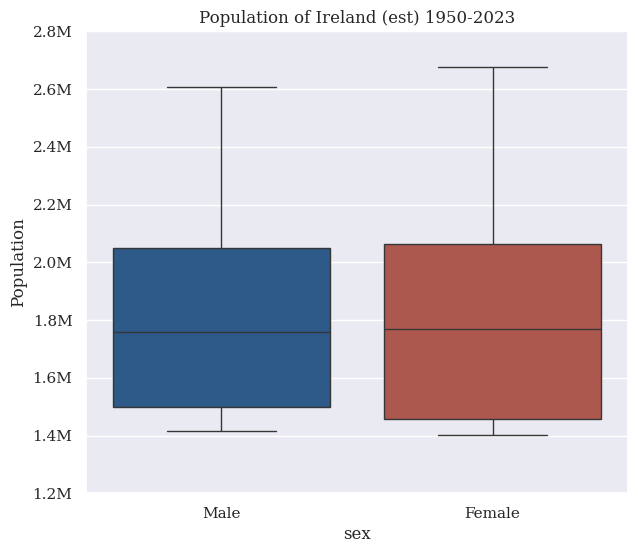

In [30]:
fig, ax = plt.subplots(figsize=(7, 6)) 
p = sns.boxplot(data=all_ages_gendered_df, y='value', x='sex', hue='sex', palette=['#005AB5', '#DC3220'], saturation=0.5)
p.set(title='Population of Ireland (est) 1950-2023', ylabel='Population')
ylabs = ['{:,.1f}M'.format(x) if x > 0.1 else 0 for x in p.get_yticks()/1000]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs);
fig.savefig(charts_folder / 'population_boxplot_genders.png')

We can see that the mean population when split by gender is roughly equal, however the distribution of the female population is slightly more right-skewed than the male equivalent.

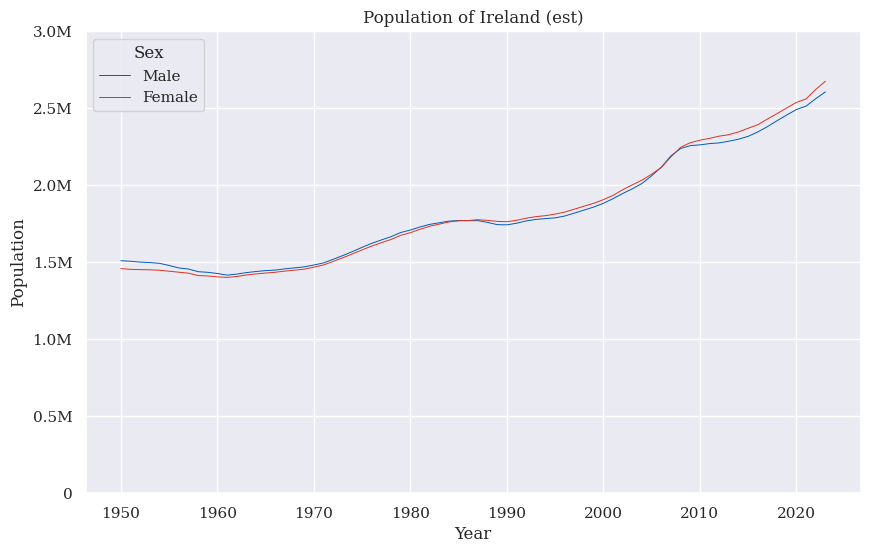

In [31]:
all_ages_gendered_df['value'] = all_ages_gendered_df['value']*1000
fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.lineplot(all_ages_gendered_df, x='year', y='value', hue='sex', palette=['#005AB5', '#DC3220'])
p.set(title='Population of Ireland (est)', xlabel='Year', ylabel='Population', ylim=(0,None))
ylabs = ['{:,.1f}M'.format(x) if x > 0.1 else 0 for x in p.get_yticks()/1000000]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
p.legend(title='Sex');

fig.savefig(charts_folder / 'population_over_time_by_gender.png')

We can again see that for most of the time series the gender balance was roughly equal - however in the 1950s there were slightly more males than females, and since the late 2000s there appear to have been more females than males. 

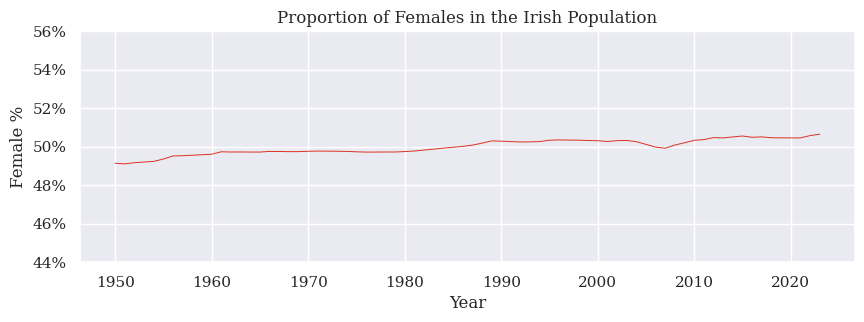

In [32]:
# all_ages_gendered_df['total'] = 
all_ages_gendered_total = all_ages_gendered_df.join(all_ages_gendered_df\
        .groupby('year')\
        .sum()\
        .rename(columns={'value': 'total'})['total'], on='year')

all_ages_gendered_total['prop'] =  (all_ages_gendered_total['value']/all_ages_gendered_total['total'])*100

fig, ax = plt.subplots(figsize=(10, 3)) 
p = sns.lineplot(all_ages_gendered_total[all_ages_gendered_total['sex']=='Female'], x='year', y='prop', hue='sex', palette=['#DC3220'])
p.set(title='Proportion of Females in the Irish Population', xlabel='Year', ylabel='Female %', ylim=(45,55))
ylabs = ['{:,.0f}%'.format(x) for x in p.get_yticks()]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
p.legend([],[], frameon=False);

fig.savefig(charts_folder / 'population_over_time_female_proportion.png')

### Population per age group

Much like the sex variable, we have overlapping age bounds within out age_group variable, so were we to add up the population per year in this case, we would be double counting in multiple instances. We would like to use a covering of all ages that is comprised of non-overlapping age ranges, and in this case we have multiple choices for what this might be. i

We could choose the one which gives us the highest level of granularity / the most levels within our age factor (i.e. - choosing under 1 year and 1-4 years, rather than 0-4 years), however we can also choose to have each of the age ranges (except 85+) be equal width. In either case we will make use of our 1-4 year or 0-4 year age range, which we cleaned earlier.

In [33]:
both_sexes_df['age_group'].unique()

array(['Under 1 year', '0 - 4 years', '0 - 14 years', '1 - 4 years',
       '5 - 9 years', '10 - 14 years', '15 - 19 years', '15 - 24 years',
       '15 years and over', '20 - 24 years', '25 - 29 years',
       '25 - 44 years', '30 - 34 years', '35 - 39 years', '40 - 44 years',
       '45 - 49 years', '45 - 64 years', '50 - 54 years', '55 - 59 years',
       '60 - 64 years', '65 - 69 years', '65 years and over',
       '70 - 74 years', '75 - 79 years', '80 - 84 years',
       '85 years and over', 'All ages'], dtype=object)

Each of the variables we want to use contains a moving 5 year window in its name. We can refer to this by splitting the range function into two iterators using itertools.tee(), advancing the second one by 1 position using next(), then moving through the lower and upper bounds of the age ranges pairwise using zip() - formatting our names as we go within a list comprehension.

In [34]:
age_lower, age_upper = itertools.tee(range(0,86,5))
next(age_upper)

covering_age_levels = [f'{low} - {high - 1} years' for low, high in zip(age_lower, age_upper)] + ['85 years and over']
covering_age_levels

['0 - 4 years',
 '5 - 9 years',
 '10 - 14 years',
 '15 - 19 years',
 '20 - 24 years',
 '25 - 29 years',
 '30 - 34 years',
 '35 - 39 years',
 '40 - 44 years',
 '45 - 49 years',
 '50 - 54 years',
 '55 - 59 years',
 '60 - 64 years',
 '65 - 69 years',
 '70 - 74 years',
 '75 - 79 years',
 '80 - 84 years',
 '85 years and over']

We can visualise this as a line chart as before, splitting on age range. However, our colour palette from before does not have enough levels to represent this. We instead choose a sequential colour palette which darkens in hue across the age ranges. The age levels are ordered, so it makes sense to use a sequential palette as opposed to a categorical one.

The resulting graphic is very busy, or something that Tufte might call "a duck" or "a puzzle", and is in general difficult to follow - we will simplify in the following section. One observation that we can note from this type of visualization however, is that we can see the same patterns occurring on each line lagged by 5 years, as we have the same population ageing and continuously falling into the next category across time, with the slopes lessening towards the higher age categories indicative of mortality at higher ages.

We can also see the youngest age categories going from being the most populous in the 1950s, to being overtaken by working ages in the 2000s. This is indicative of a shift in demographic makeup, although it is unclear from this chart alone whether that is driven by birth rates or migration. 

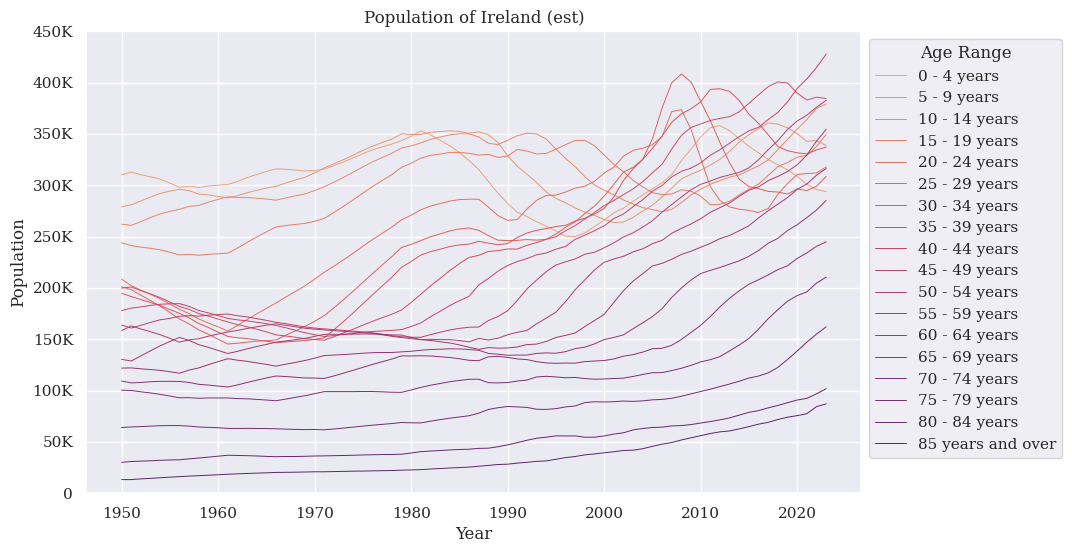

In [35]:
both_sexes_age_df =  both_sexes_df[both_sexes_df['age_group'].isin(covering_age_levels)]

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.lineplot(both_sexes_age_df, x='year', y='value', hue='age_group', palette=sns.color_palette("flare", n_colors=len(covering_age_levels)))
p.set(title='Population of Ireland (est)', xlabel='Year', ylabel='Population', ylim=(0,None))
ylabs = ['{:,.0f}K'.format(x) if x > 0.1 else 0 for x in p.get_yticks()]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
p.legend(title='Age Range')
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

fig.savefig(charts_folder / 'population_over_time_age_split.png')

We can use an alternate covering of the span of ages to make the above visualization less cluttered, and we can clearly see the number of 0-14 year olds declining in the 90s until the mid 2000s, and the number of 25-44 year olds increases dramatically over this timeframe.

As we are only working with 5 levels in this chart, we elect to switch the palette to one with more variation, so that individual trends can be followed more easily, rather than having the hue change continuously with age as before.

One thing to note here though, is that the age ranges should not necessarily be compared to one another, as the number of ages in each bucket is not equal.

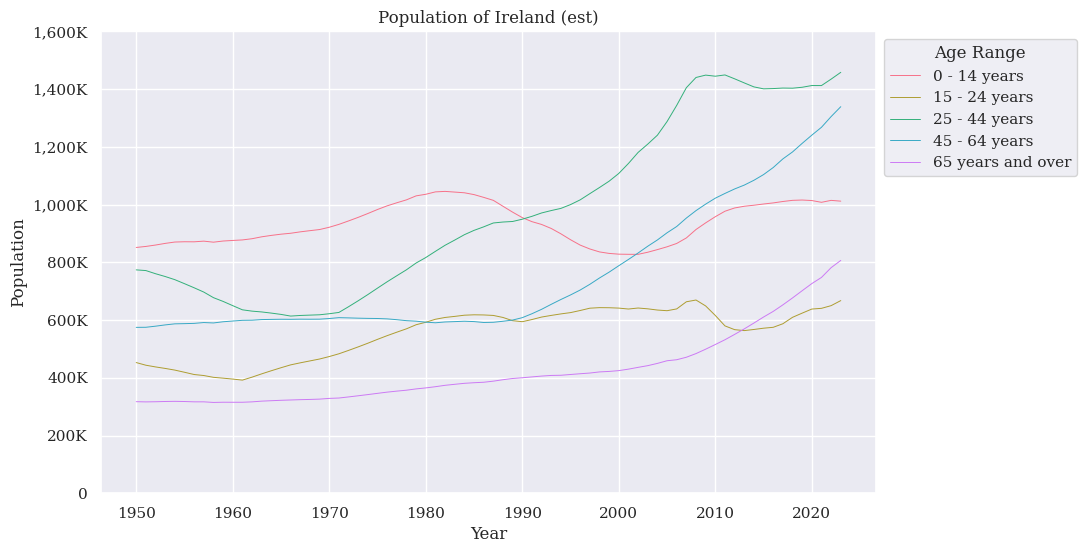

In [36]:
alt_cover =  ['0 - 14 years', '15 - 24 years', '25 - 44 years', '45 - 64 years','65 years and over']

alt_both_sexes_age_df =  both_sexes_df[both_sexes_df['age_group'].isin(alt_cover)]

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.lineplot(alt_both_sexes_age_df, x='year', y='value', hue='age_group', palette=sns.color_palette("husl", n_colors=len(alt_cover)))
p.set(title='Population of Ireland (est)', xlabel='Year', ylabel='Population', ylim=(0,None))
ylabs = ['{:,.0f}K'.format(x) if x > 0.1 else 0 for x in p.get_yticks()]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
p.legend(title='Age Range')
sns.move_legend(p, "upper left", bbox_to_anchor=(1, 1))

fig.savefig(charts_folder / 'population_over_time_age_split_simplified.png')

We would like to look at population age composition separated by year, however 70+ charts would be excessive, so we will bucket the years together into a range, similar to the age_range variable. Grouping by decade would be the obvious choice, however we can see from the above chart that some of the rapid changes in demographic occur over a shorter period than that, so we will choose buckets of 5 years. 

As we will be looking at multiple individual charts, we can also reintroduce gender at this point without creating too much visual clutter.

In [37]:
sexes_age_df =  sexes_df[sexes_df['age_group'].isin(covering_age_levels)].copy()

# pull the years back to the half decade below them with floor division - https://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
sexes_age_df['half_decade'] = (sexes_age_df.year//5)*5 
sexes_age_df['half_decade'] = sexes_age_df['half_decade'].apply(lambda x: f"{x} - {x+4}")

# sexes_age_df['decade'] = (sexes_age_df.year//10)*10 
# sexes_age_df['decade'] = sexes_age_df['decade'].apply(lambda x: f"{x}s")

half_decade_df = sexes_age_df.groupby(['half_decade', 'age_group', 'sex'])[['value']].mean().reset_index()                                                               
half_decade_df['value'] = half_decade_df['value']*[-1 if x == 'Female' else 1 for x in half_decade_df['sex']]
half_decade_df.head()

,half_decade,age_group,sex,value
0,1950 - 1954,0 - 4 years,Female,-151.18
1,1950 - 1954,0 - 4 years,Male,158.30
2,1950 - 1954,10 - 14 years,Female,-130.48
3,1950 - 1954,10 - 14 years,Male,135.18
4,1950 - 1954,15 - 19 years,Female,-114.98


We can visualise the changing population makeup across genders and ages using multiple population pyramids (or age structure diagrams), which are a type of paired bar plots typically used for this purpose (Wilson 2016). Tufte argues (p. 170-175) in favour of these "small multiple" style visualizations in order to observe a change over time.

This shows that the population in Ireland has shifted from having a relatively wide base - indicative of many births and young people - to having a wide middle and comparatively narrower base, which may indicate a lower birth rate. A particularly notable change in the width of the middle ages can be seen in 2000-2010 - which we expected to see given the above line chart.

This could also explain the higher percentage of females in recent years we saw previously, as women have a longer life expectancy than men (Gryclewska, 2016), therefore an aging population would naturally be comprised of more women - the gender difference in the older cohorts can be seen clearly in the plots from 2000 onwards.

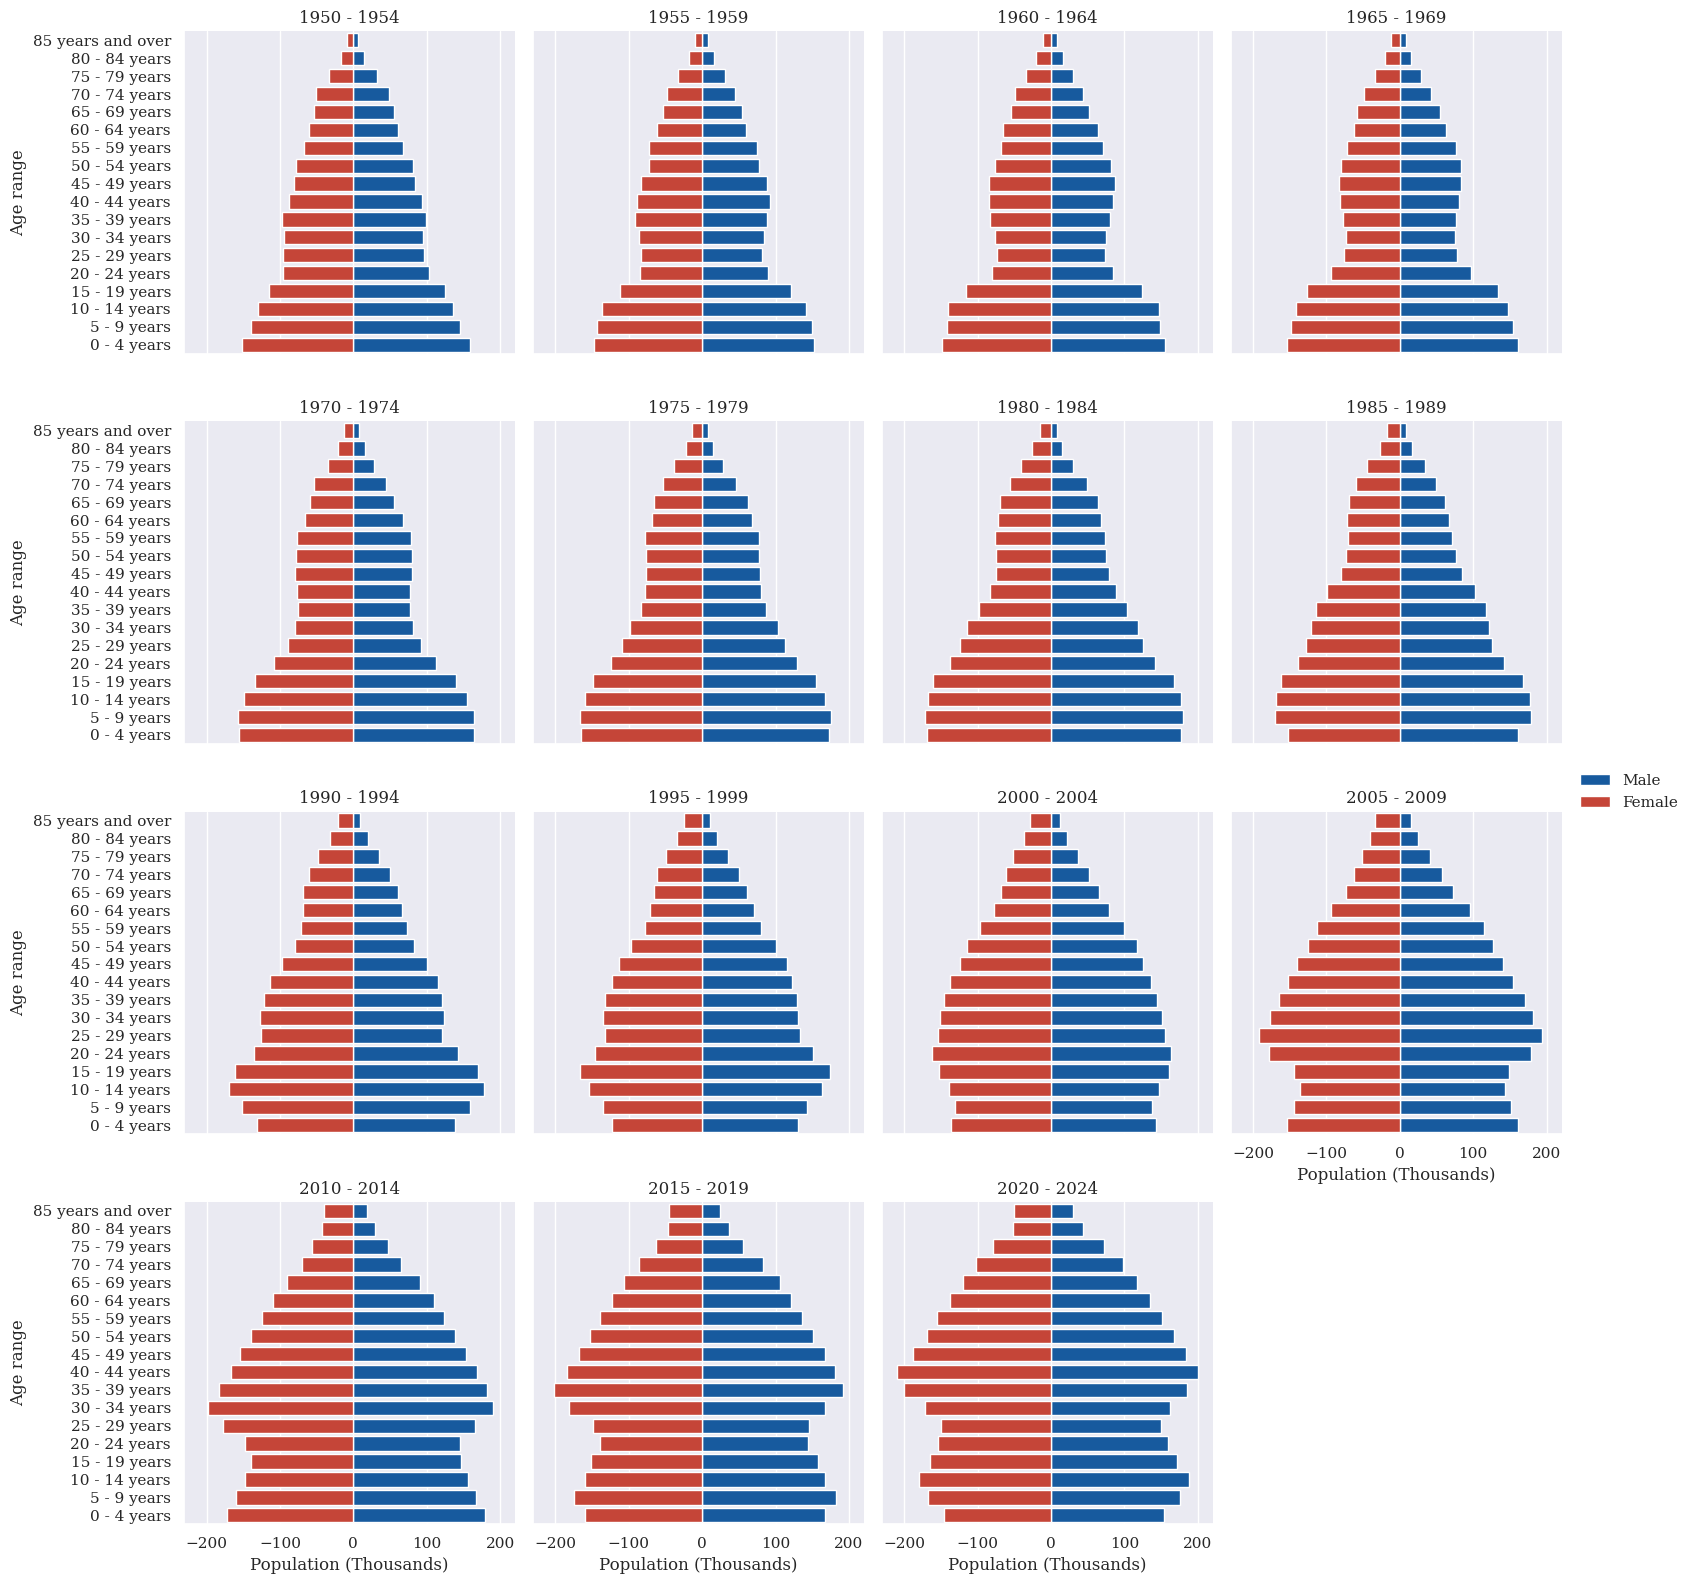

In [38]:
p = sns.FacetGrid(half_decade_df, col='half_decade', col_wrap=4, margin_titles=True, height=4)
p.map_dataframe(sns.barplot, # map_dataframe exposes column names from the FacetGrid object's data for mapping to chart aesthetics
    x='value', 
    y='age_group', 
    hue='sex', 
    hue_order=['Male', 'Female'],
    palette=['#005AB5', '#DC3220'], 
    orient='horizontal', 
    order=covering_age_levels[::-1], # reverse the age levels so youngest is at the bottom
    dodge=False) # Have the male and female bars be on the same Y level
p.add_legend()
p.set_titles(template="{col_name}")
# TODO: I'm unsure how to change x tick labels within a FacetGrid - Ideally I'd have positive values displayed along negative X axis and add a K suffix
p.set_xlabels(label='Population (Thousands)')
p.set_ylabels(label='Age range');

p.savefig(charts_folder / 'population_pyramid_multiples.png')

# Migration Data 

## Cleaning & Imputation

We would like to try and gain some understanding of what is driving some of the population changes seen above, and bringing in migration data will help us to do this.

On loading the migration data we see that again, we have missing values in the value column. These primarily appear to effect the net migration and All ages datapoints more often, so we can see if they can be repaired using the filled values as above.

In [39]:
migration_df = read_csv_and_fix_names(data_folder / 'migration_table.csv')
print(migration_df.dtypes, '\n')
print(f'Row count: {len(migration_df)}', '\n')
migration_df.head(n=20)

statistic                  object
statistic_label            object
tlist(a1)                   int64
year                        int64
c02076v03371               object
age_group                  object
c02199v02655               object
sex                        object
c02542v03077                int64
inward_or_outward_flow     object
unit                       object
value                     float64
dtype: object 

Row count: 1998 



,statistic,statistic_label,tlist(a1),year,c02076v03371,age_group,c02199v02655,sex,c02542v03077,inward_or_outward_flow,unit,value
0,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,1,Net migration,Thousand,-23.0
1,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,4,Emigrants: All destinations,Thousand,40.2
2,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,5,Immigrants: All origins,Thousand,17.2
3,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,1,Net migration,Thousand,NaN
4,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,4,Emigrants: All destinations,Thousand,NaN
5,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,5,Immigrants: All origins,Thousand,NaN
6,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,2,Female,1,Net migration,Thousand,NaN
7,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,2,Female,4,Emigrants: All destinations,Thousand,NaN
8,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,2,Female,5,Immigrants: All origins,Thousand,NaN
9,PEA03,Estimated Migration (Persons in April),1987,1987,215,0 - 14 years,-,Both sexes,1,Net migration,Thousand,NaN


In [40]:
# Checking the levels of age_group to see how we can join back to population estimates table
migration_df['age_group'].unique()

array(['All ages', '0 - 14 years', '15 - 24 years', '25 - 44 years',
       '45 - 64 years', '65 years and over'], dtype=object)

In [41]:
## Null values across categorical variables
print(migration_df.loc[pd.isna(migration_df.value)]['age_group'].value_counts(), '\n')
print(migration_df.loc[pd.isna(migration_df.value)]['inward_or_outward_flow'].value_counts())

age_group
All ages             90
0 - 14 years         45
15 - 24 years        45
25 - 44 years        45
45 - 64 years        45
65 years and over    45
Name: count, dtype: int64 

inward_or_outward_flow
Net migration                  255
Emigrants: All destinations     30
Immigrants: All origins         30
Name: count, dtype: int64


In [42]:
pivoted_migration_df = migration_df.pivot(columns=['inward_or_outward_flow'], index=['year', 'sex', 'age_group'], values='value')
pivoted_migration_df.head(n=20)

inward_or_outward_flow             Emigrants: All destinations  \
year sex        age_group                                        
1987 Both sexes 0 - 14 years                               2.8   
                15 - 24 years                             24.0   
                25 - 44 years                             11.8   
                45 - 64 years                              1.7   
                65 years and over                          0.0   
                All ages                                  40.2   
     Female     0 - 14 years                               1.3   
                15 - 24 years                             11.7   
                25 - 44 years                              4.9   
                45 - 64 years                              0.7   
                65 years and over                          0.0   
                All ages                                   NaN   
     Male       0 - 14 years                               1.4   
                15 - 24 years                             12.3   
                25 - 44 years                              6.9   
                45 - 64 years                              1.0   
                65 years and over                          0.0   
                All ages                                   NaN   
1988 Both sexes 0 - 14 years                               8.3   
                15 - 24 years                             31.2   

inward_or_outward_flow             Immigrants: All origins  Net migration  
year sex        age_group                                                  
1987 Both sexes 0 - 14 years                           3.1            NaN  
                15 - 24 years                          5.1            NaN  
                25 - 44 years                          6.1            NaN  
                45 - 64 years                          1.8            NaN  
                65 years and over                      1.1            NaN  
                All ages                              17.2          -23.0  
     Female     0 - 14 years                           1.8            NaN  
                15 - 24 years                          3.2            NaN  
                25 - 44 years                          2.7            NaN  
                45 - 64 years                          0.8            NaN  
                65 years and over                      0.6            NaN  
                All ages                               NaN            NaN  
     Male       0 - 14 years                           1.3            NaN  
                15 - 24 years                          1.9            NaN  
                25 - 44 years                          3.4            NaN  
                45 - 64 years                          1.0            NaN  
                65 years and over                      0.5            NaN  
                All ages                               NaN            NaN  
1988 Both sexes 0 - 14 years                           3.0            NaN  
                15 - 24 years                          5.4            NaN

In [43]:
pivoted_migration_df.tail(n=20)

inward_or_outward_flow             Emigrants: All destinations  \
year sex        age_group                                        
2022 Male       65 years and over                          1.1   
                All ages                                  29.6   
2023 Both sexes 0 - 14 years                               5.5   
                15 - 24 years                             19.9   
                25 - 44 years                             32.3   
                45 - 64 years                              5.3   
                65 years and over                          1.0   
                All ages                                  64.0   
     Female     0 - 14 years                               2.6   
                15 - 24 years                             12.3   
                25 - 44 years                             15.2   
                45 - 64 years                              2.2   
                65 years and over                          0.6   
                All ages                                  32.9   
     Male       0 - 14 years                               2.9   
                15 - 24 years                              7.5   
                25 - 44 years                             17.2   
                45 - 64 years                              3.0   
                65 years and over                          0.4   
                All ages                                  31.0   

inward_or_outward_flow             Immigrants: All origins  Net migration  
year sex        age_group                                                  
2022 Male       65 years and over                      1.7            0.5  
                All ages                              49.2           19.6  
2023 Both sexes 0 - 14 years                          21.8           16.3  
                15 - 24 years                         23.8            3.9  
                25 - 44 years                         75.1           42.7  
                45 - 64 years                         16.9           11.7  
                65 years and over                      4.0            3.0  
                All ages                             141.6           77.7  
     Female     0 - 14 years                          10.8            8.2  
                15 - 24 years                         13.7            1.4  
                25 - 44 years                         38.2           23.1  
                45 - 64 years                         10.3            8.1  
                65 years and over                      2.5            1.8  
                All ages                              75.5           42.6  
     Male       0 - 14 years                          11.1            8.2  
                15 - 24 years                         10.0            2.5  
                25 - 44 years                         36.8           19.6  
                45 - 64 years                          6.6            3.6  
                65 years and over                      1.5            1.1  
                All ages                              66.1           35.1

As suspected, the net migration values are not missing in more recent data. It's possible that this was not originally calculated when records began. We can easily fill in the NaNs by subtracting emigrants from immigrants with the data in this pivoted form, however we will first need to address the other missing values, or else we would be left with missing values corresponding to All ages.

We will first pivot with the age group across the columns, repair All ages by adding the figures for the other ages together, then repivot with inward_or_outward_flow across the columns, then finally repair Net Migration.

In [44]:
pivoted_migration_df = migration_df.pivot(columns=['age_group'], index=['year', 'sex', 'inward_or_outward_flow'], values='value')
pivoted_migration_df.head()

age_group                                    0 - 14 years  15 - 24 years  \
year sex        inward_or_outward_flow                                     
1987 Both sexes Emigrants: All destinations           2.8           24.0   
                Immigrants: All origins               3.1            5.1   
                Net migration                         NaN            NaN   
     Female     Emigrants: All destinations           1.3           11.7   
                Immigrants: All origins               1.8            3.2   

age_group                                    25 - 44 years  45 - 64 years  \
year sex        inward_or_outward_flow                                      
1987 Both sexes Emigrants: All destinations           11.8            1.7   
                Immigrants: All origins                6.1            1.8   
                Net migration                          NaN            NaN   
     Female     Emigrants: All destinations            4.9            0.7   
                Immigrants: All origins                2.7            0.8   

age_group                                    65 years and over  All ages  
year sex        inward_or_outward_flow                                    
1987 Both sexes Emigrants: All destinations                0.0      40.2  
                Immigrants: All origins                    1.1      17.2  
                Net migration                              NaN     -23.0  
     Female     Emigrants: All destinations                0.0       NaN  
                Immigrants: All origins                    0.6       NaN

In [45]:
# Confirm that the missing values in the non-age group variables are only on the net migration rows
pd.isna(pivoted_migration_df.loc[pivoted_migration_df.index.get_level_values('inward_or_outward_flow') != 'Net migration']).sum()

age_group
0 - 14 years          0
15 - 24 years         0
25 - 44 years         0
45 - 64 years         0
65 years and over     0
All ages             60
dtype: int64

In [46]:
age_columns = [x for x in pivoted_migration_df.columns if x != 'All ages']
pivoted_migration_df['All ages'] = pivoted_migration_df.loc[:, age_columns].sum(axis=1)
pivoted_migration_df.head()

age_group                                    0 - 14 years  15 - 24 years  \
year sex        inward_or_outward_flow                                     
1987 Both sexes Emigrants: All destinations           2.8           24.0   
                Immigrants: All origins               3.1            5.1   
                Net migration                         NaN            NaN   
     Female     Emigrants: All destinations           1.3           11.7   
                Immigrants: All origins               1.8            3.2   

age_group                                    25 - 44 years  45 - 64 years  \
year sex        inward_or_outward_flow                                      
1987 Both sexes Emigrants: All destinations           11.8            1.7   
                Immigrants: All origins                6.1            1.8   
                Net migration                          NaN            NaN   
     Female     Emigrants: All destinations            4.9            0.7   
                Immigrants: All origins                2.7            0.8   

age_group                                    65 years and over  All ages  
year sex        inward_or_outward_flow                                    
1987 Both sexes Emigrants: All destinations                0.0      40.3  
                Immigrants: All origins                    1.1      17.2  
                Net migration                              NaN       0.0  
     Female     Emigrants: All destinations                0.0      18.6  
                Immigrants: All origins                    0.6       9.1

In [47]:
# the sum added the nans together to 0, which we don't want 
pivoted_migration_df['All ages'] = pivoted_migration_df.apply(lambda row: np.nan if any(pd.isna(row)) else row['All ages'] , axis=1)
pivoted_migration_df.head()

age_group                                    0 - 14 years  15 - 24 years  \
year sex        inward_or_outward_flow                                     
1987 Both sexes Emigrants: All destinations           2.8           24.0   
                Immigrants: All origins               3.1            5.1   
                Net migration                         NaN            NaN   
     Female     Emigrants: All destinations           1.3           11.7   
                Immigrants: All origins               1.8            3.2   

age_group                                    25 - 44 years  45 - 64 years  \
year sex        inward_or_outward_flow                                      
1987 Both sexes Emigrants: All destinations           11.8            1.7   
                Immigrants: All origins                6.1            1.8   
                Net migration                          NaN            NaN   
     Female     Emigrants: All destinations            4.9            0.7   
                Immigrants: All origins                2.7            0.8   

age_group                                    65 years and over  All ages  
year sex        inward_or_outward_flow                                    
1987 Both sexes Emigrants: All destinations                0.0      40.3  
                Immigrants: All origins                    1.1      17.2  
                Net migration                              NaN       NaN  
     Female     Emigrants: All destinations                0.0      18.6  
                Immigrants: All origins                    0.6       9.1

In [48]:
molten_migration_df = pivoted_migration_df.reset_index().melt(id_vars=['year', 'sex', 'inward_or_outward_flow'])
molten_migration_df.head()

,year,sex,inward_or_outward_flow,age_group,value
0,1987,Both sexes,Emigrants: All destinations,0 - 14 years,2.8
1,1987,Both sexes,Immigrants: All origins,0 - 14 years,3.1
2,1987,Both sexes,Net migration,0 - 14 years,NaN
3,1987,Female,Emigrants: All destinations,0 - 14 years,1.3
4,1987,Female,Immigrants: All origins,0 - 14 years,1.8


In [49]:
repivoted_migration_df = molten_migration_df.pivot(columns=['inward_or_outward_flow'], index=['year', 'sex', 'age_group'], values='value')
repivoted_migration_df['Net migration'] = repivoted_migration_df['Immigrants: All origins'] - repivoted_migration_df['Emigrants: All destinations'] 
repivoted_migration_df.head(n=10) 

inward_or_outward_flow             Emigrants: All destinations  \
year sex        age_group                                        
1987 Both sexes 0 - 14 years                               2.8   
                15 - 24 years                             24.0   
                25 - 44 years                             11.8   
                45 - 64 years                              1.7   
                65 years and over                          0.0   
                All ages                                  40.3   
     Female     0 - 14 years                               1.3   
                15 - 24 years                             11.7   
                25 - 44 years                              4.9   
                45 - 64 years                              0.7   

inward_or_outward_flow             Immigrants: All origins  Net migration  
year sex        age_group                                                  
1987 Both sexes 0 - 14 years                           3.1            0.3  
                15 - 24 years                          5.1          -18.9  
                25 - 44 years                          6.1           -5.7  
                45 - 64 years                          1.8            0.1  
                65 years and over                      1.1            1.1  
                All ages                              17.2          -23.1  
     Female     0 - 14 years                           1.8            0.5  
                15 - 24 years                          3.2           -8.5  
                25 - 44 years                          2.7           -2.2  
                45 - 64 years                          0.8            0.1

In [50]:
cleaned_migration_df = repivoted_migration_df.reset_index().melt(id_vars=['year', 'sex', 'age_group'])
print(pd.isna(cleaned_migration_df).sum(), '\n')
print(f'Row count: {len(cleaned_migration_df)}', '\n')
cleaned_migration_df.to_csv(data_folder / "cleaned_migration_data.csv", index=False)
cleaned_migration_df.head(n=10)

year                      0
sex                       0
age_group                 0
inward_or_outward_flow    0
value                     0
dtype: int64 

Row count: 1998 



,year,sex,age_group,inward_or_outward_flow,value
0,1987,Both sexes,0 - 14 years,Emigrants: All destinations,2.8
1,1987,Both sexes,15 - 24 years,Emigrants: All destinations,24.0
2,1987,Both sexes,25 - 44 years,Emigrants: All destinations,11.8
3,1987,Both sexes,45 - 64 years,Emigrants: All destinations,1.7
4,1987,Both sexes,65 years and over,Emigrants: All destinations,0.0
5,1987,Both sexes,All ages,Emigrants: All destinations,40.3
6,1987,Female,0 - 14 years,Emigrants: All destinations,1.3
7,1987,Female,15 - 24 years,Emigrants: All destinations,11.7
8,1987,Female,25 - 44 years,Emigrants: All destinations,4.9
9,1987,Female,45 - 64 years,Emigrants: All destinations,0.7


We now have a cleaned migration dataset in the same format we started with, with the missing values repaired. 

## Migration Data Exploration

In order to plot this data, we will want to work with the pivoted form. We can display emigration and immigration as bars, with an accompanying line denoting net migration. Although emigration results in a reduction in the population and immigration results in an increase in the population, I have elected not to use typical increasing / decreasing colour choices (blue for increasing, red for decreasing, etc.) as these may also be interpreted as ascribing goodness or badness to either phenomenon, which I want to avoid.

In [51]:
both_sexes_all_ages_migration_df = cleaned_migration_df[
    (cleaned_migration_df['age_group'] == 'All ages') & 
    (cleaned_migration_df['sex'] == 'Both sexes')
    ].pivot(columns=['inward_or_outward_flow'], index=['year', 'sex', 'age_group'], values='value').reset_index().copy()
both_sexes_all_ages_migration_df['Emigrants: All destinations'] =  both_sexes_all_ages_migration_df['Emigrants: All destinations']*-1
both_sexes_all_ages_migration_df.head()

inward_or_outward_flow,year,sex,age_group,Emigrants: All destinations,Immigrants: All origins,Net migration
0,1987,Both sexes,All ages,-40.3,17.2,-23.1
1,1988,Both sexes,All ages,-61.0,19.2,-41.8
2,1989,Both sexes,All ages,-70.5,26.7,-43.8
3,1990,Both sexes,All ages,-56.3,33.4,-22.9
4,1991,Both sexes,All ages,-35.4,33.3,-2.1


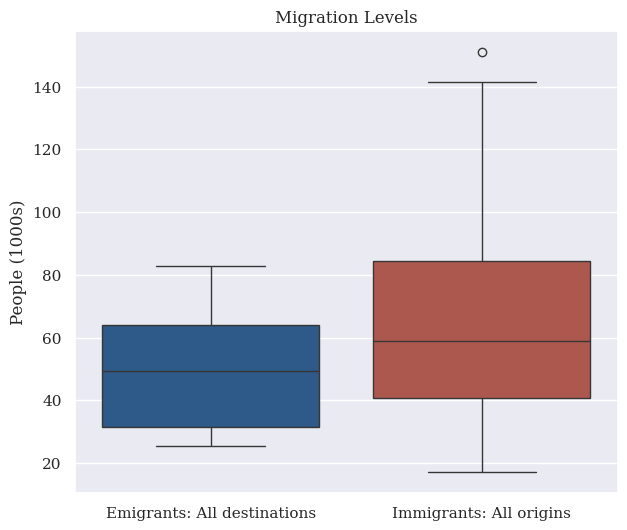

In [110]:
unpivoted_migration_totals_df = both_sexes_all_ages_migration_df = cleaned_migration_df[
    (cleaned_migration_df['age_group'] == 'All ages') & 
    (cleaned_migration_df['sex'] == 'Both sexes') &
    (cleaned_migration_df['inward_or_outward_flow'] != 'Net migration')
    ]
fig, ax = plt.subplots(figsize=(7, 6)) 
p = sns.boxplot(data=unpivoted_migration_totals_df, y='value', x='inward_or_outward_flow', hue='inward_or_outward_flow', palette=['#005AB5', '#DC3220'], saturation=0.5)
p.set(title='Migration Levels', ylabel='People (1000s)', xlabel="");
fig.savefig(charts_folder / 'migration_boxplot.png')

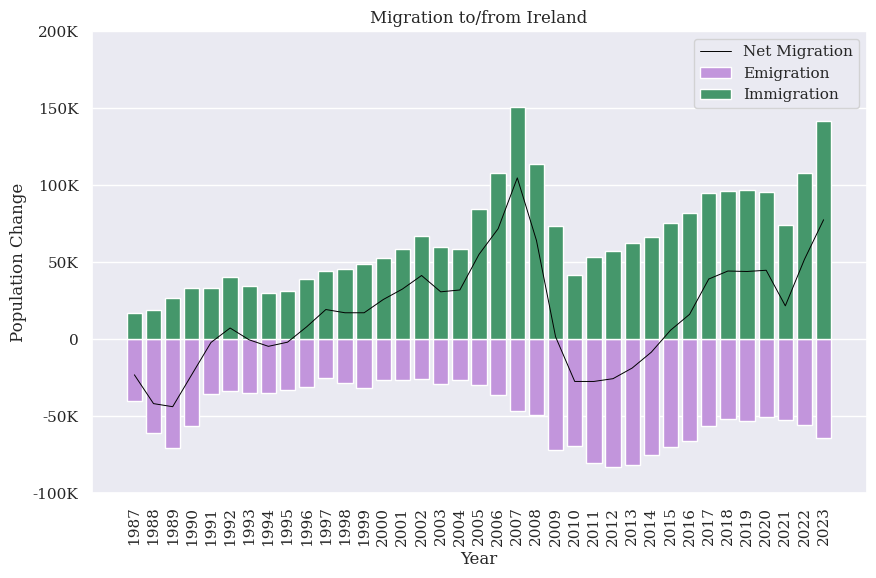

In [99]:
fig = plt.figure(figsize=(10, 6)) 
p = sns.barplot(both_sexes_all_ages_migration_df , x='year', y='Emigrants: All destinations', label='Emigration', color='#C589E8')
sns.barplot(both_sexes_all_ages_migration_df , x='year', y='Immigrants: All origins', label='Immigration', color='#37a56a')
sns.lineplot(both_sexes_all_ages_migration_df , x=p.get_xticks(), y='Net migration', label="Net Migration", color='#000000')
p.set(title='Migration to/from Ireland', xlabel="Year", ylabel="Population Change")
ylabs = ['{:,.0f}K'.format(x) if abs(x) > 0.1 else 0 for x in p.get_yticks()]
p.set_yticks(p.get_yticks())
p.set_yticklabels(ylabs)
plt.xticks(rotation=90);
fig.savefig(charts_folder / 'migration_trends.png')

Low immigration in 2021 - is this due to covid?

## Binomial Modelling

We can model the relationship between emigration and immigration using a binomial distribution; where each year is an independent Bernoulli trial with success being defined as immigration > emigration, or that net migration contributes to population growth. If we denote 1 as a success and 0 as a failure, we can estimate the success probability over all years by taking the mean of our success column.

We can then draw up the binomial distribution for the number of successes in a decade using the binom.pmf() function by setting our number of trials to 10. As our estimated P(X=x) is > 0.5 our distribution is left-skewed (Weiss, 2017).

In [53]:
both_sexes_all_ages_migration_df['success'] = both_sexes_all_ages_migration_df['Net migration'] > 0 

0.6486486486486487
[2.866924674125702e-05, 0.0005292784013770532, 0.0043970821037478255, 0.021647173433835442, 0.06993702186316067, 0.15493740228146363, 0.23836523427917494, 0.2514622251736352, 0.17408923281251668, 0.07142122371795558, 0.013185456686391797]


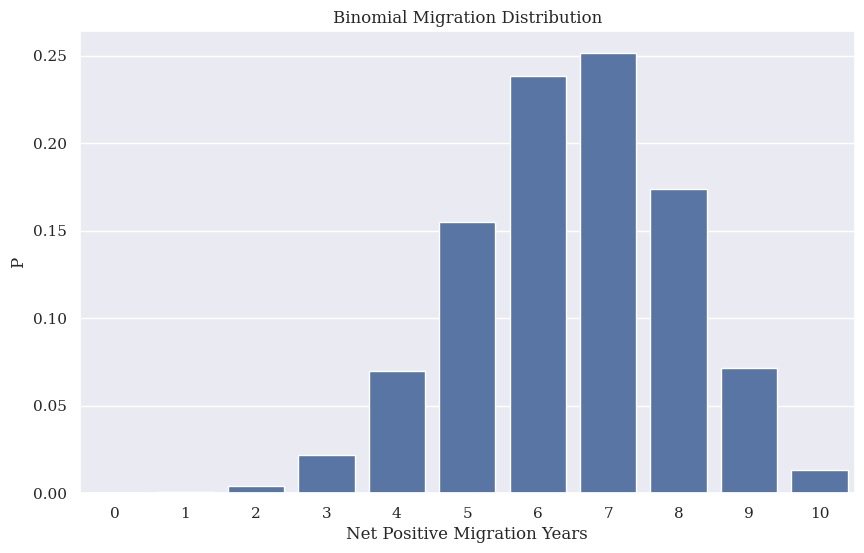

In [54]:
success_prob = np.mean(both_sexes_all_ages_migration_df['success'])
print(success_prob)

distribution = [binom.pmf(x, 10, success_prob) for x in range(11)]
print(distribution)

fig = plt.figure(figsize=(10, 6)) 
p = sns.barplot(x=range(11), y=distribution)
p.set(title='Binomial Migration Distribution', xlabel='Net Positive Migration Years', ylabel="P");
fig.savefig(charts_folder / 'binomial_migration.png')

In [57]:
success_pre_2000s = sum(both_sexes_all_ages_migration_df.loc[(both_sexes_all_ages_migration_df['year'] >= 1990) & (both_sexes_all_ages_migration_df['year'] < 2000), 'success'])
success_post_2000s = sum(both_sexes_all_ages_migration_df.loc[(both_sexes_all_ages_migration_df['year'] >= 2000) & (both_sexes_all_ages_migration_df['year'] < 2010), 'success'])

(
 (success_pre_2000s, binom.pmf(success_pre_2000s, 10, success_prob)), 
 (success_post_2000s, binom.pmf(success_post_2000s, 10, success_prob))
)

((5, 0.15493740228146363), (10, 0.013185456686391797))

Looking at the decades before and after the millenium, we can see that the 90s had 5 successes, which according to our model had a probability of 0.155 of occurring, wheras the 2000s had 10 successes, which had only a probability of 0.013 of occurring. This indicates that the distribution of successes may have shifted over time, as the probability of the post 2000s data occurring according to our model is low.


## Poisson Modelling

We can also migration using a poisson distribution - in this case, we will treat one immigration event as a success, so we can calculate lambda as the mean number of immigrants per year.

We can use this to estimate the probability that immigration is greater than the mean emigration level, which over the wholde dataset comes out to have a pobability of 0.487

In [55]:
mu = np.mean(both_sexes_all_ages_migration_df['Immigrants: All origins'])

mean_emigration = np.mean(both_sexes_all_ages_migration_df['Immigrants: All origins'])

# P(X > mean_emigration)
1 - poisson.cdf(mean_emigration, mu)

0.4868359315324564

Also, by drawing successively larger random samples from this distribution we can see how it converges to a normal distribution in the limit.

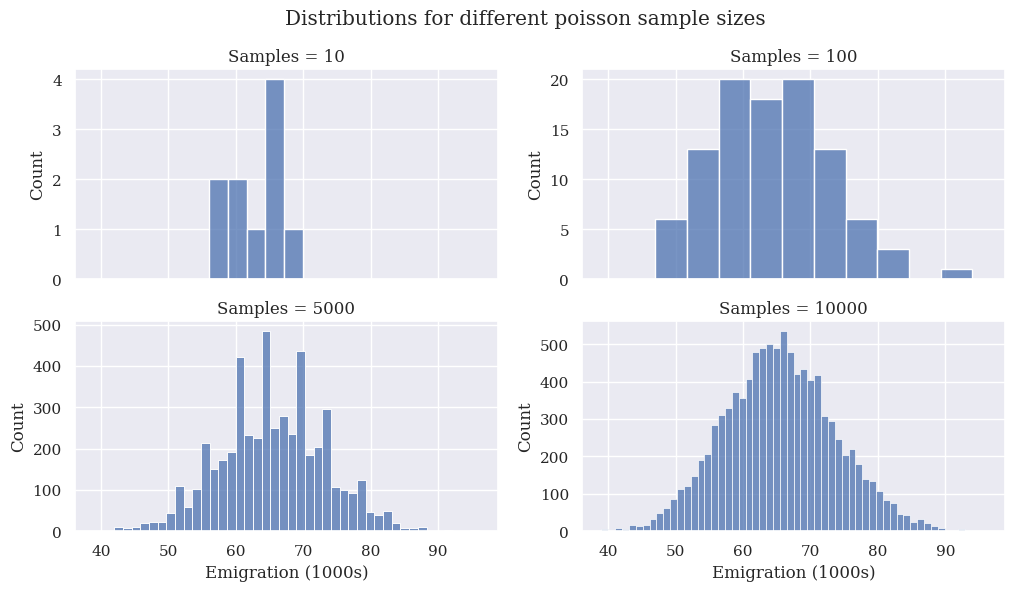

In [102]:
random.seed(0)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True) 
fig.suptitle("Distributions for different poisson sample sizes")
for i, ax in zip([10, 100, 5000, 10000], axs.ravel()):
    x = poisson.rvs(mu=mu, size=i)
    sns.histplot(x, ax=ax)
    ax.set_title(f"Samples = {i}")
    ax.set_xlabel('Emigration (1000s)')
fig.savefig(charts_folder / 'poisson_convergence.png')

## Comparing pre & post 2008 Emigration

There was a period of net emigration after the 2008 crash. Looking at the above line and bar graph there was an inflection point in 2008, and it looks like before and after this our emigration figures can be thought of as coming from different distributions.

We can use a qqplot to check the emigration variable's distribution agains a theoretical normal distribution. Although, we would expect emigration to increase as the overall population increases, so in this case we can look at emigration as a percentage of total population to control for this. 

In [58]:
pop_migration_df = all_ages_df.rename(columns={'value': 'population'}).merge(both_sexes_all_ages_migration_df, on=['year', 'sex', 'age_group'])
pop_migration_df['emigration_pop_pct'] = (np.abs(pop_migration_df['Emigrants: All destinations'])*1000)/pop_migration_df['population']
pop_migration_df['immigration_pop_pct'] = (np.abs(pop_migration_df['Immigrants: All origins'])*1000)/pop_migration_df['population']
pop_migration_df['net_migration_pct'] = pop_migration_df['immigration_pop_pct'] - pop_migration_df['emigration_pop_pct']
pop_migration_df.head()

,statistic,statistic_label,tlist(a1),year,c02076v02508,age_group,c02199v02655,sex,unit,population,Emigrants: All destinations,Immigrants: All origins,Net migration,success,emigration_pop_pct,immigration_pop_pct,net_migration_pct
0,PEA01,Population Estimates (Persons in April),1987,1987,-,All ages,-,Both sexes,Thousand,3546500.0,-40.3,17.2,-23.1,False,0.011363,0.004850,-0.006513
1,PEA01,Population Estimates (Persons in April),1988,1988,-,All ages,-,Both sexes,Thousand,3530700.0,-61.0,19.2,-41.8,False,0.017277,0.005438,-0.011839
2,PEA01,Population Estimates (Persons in April),1989,1989,-,All ages,-,Both sexes,Thousand,3509500.0,-70.5,26.7,-43.8,False,0.020088,0.007608,-0.012480
3,PEA01,Population Estimates (Persons in April),1990,1990,-,All ages,-,Both sexes,Thousand,3505800.0,-56.3,33.4,-22.9,False,0.016059,0.009527,-0.006532
4,PEA01,Population Estimates (Persons in April),1991,1991,-,All ages,-,Both sexes,Thousand,3525700.0,-35.4,33.3,-2.1,False,0.010041,0.009445,-0.000596


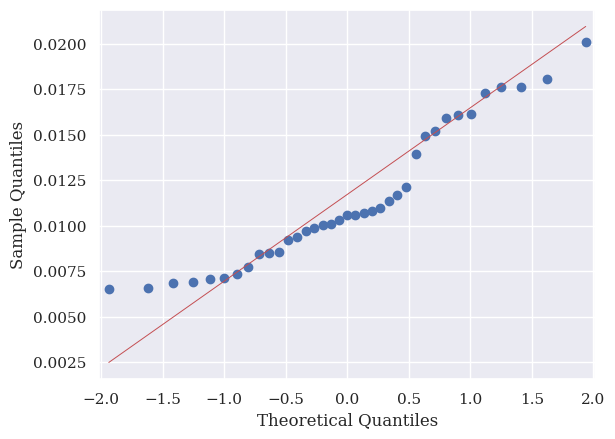

In [59]:
fig = sm.qqplot(pop_migration_df['emigration_pop_pct'], line='q');
fig.savefig(charts_folder / 'emigration_qq.png')

This is a poor fit - implying a nonnormal distribution for the overall series.

The inflection point at 0.5 indicates bimodality - something we can again see with a histogram. So we should look at separate qq plots pre and post 2008 to see if these partitoned series are distributed normally.

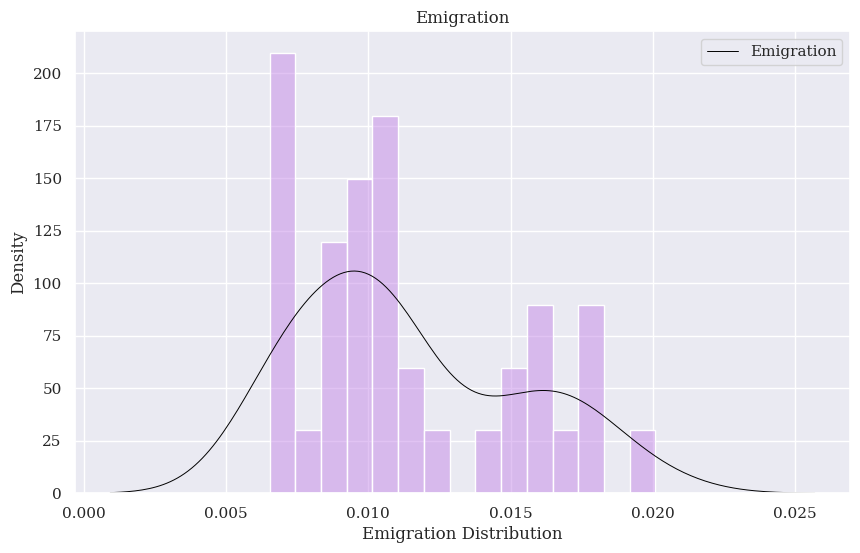

In [60]:
fig = plt.figure(figsize=(10, 6)) 
numrows = len(pop_migration_df)
p = sns.histplot(pop_migration_df , x='emigration_pop_pct', hue=['Emigration']*numrows, palette=['#C589E8'], bins=15, stat='density')
sns.kdeplot(pop_migration_df , x='emigration_pop_pct', hue=['Emigration']*numrows, palette=['#000000'])
p.set_title(f"Emigration")
p.set_xlabel('Emigration Distribution')
fig.savefig(charts_folder / 'emigration_histogram.png')


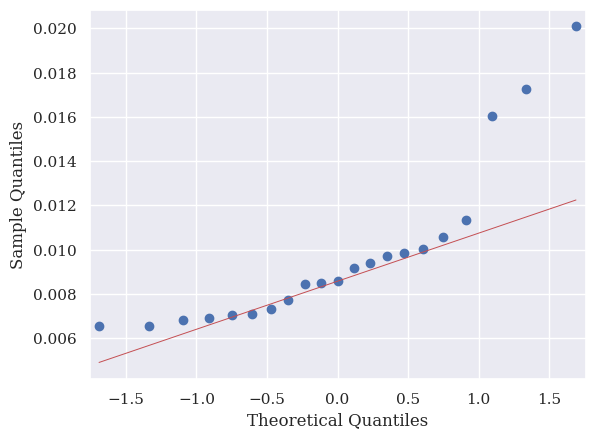

In [61]:
pre_08 = pop_migration_df.loc[pop_migration_df['year'] < 2008, 'emigration_pop_pct']
post_08 = pop_migration_df.loc[pop_migration_df['year'] >= 2008, 'emigration_pop_pct']

fig = sm.qqplot(pre_08, line='q');
fig.savefig(charts_folder / 'pre_08_qq.png')

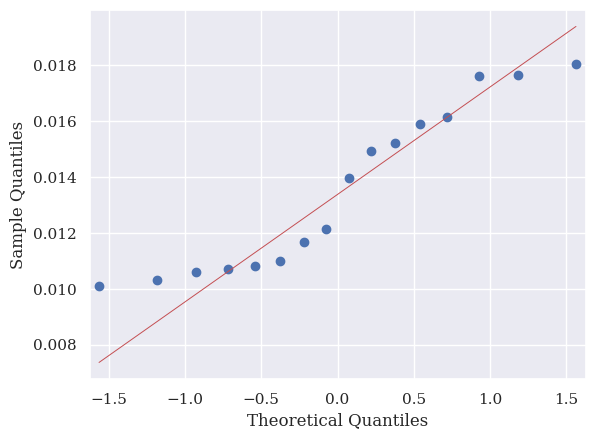

In [62]:
fig = sm.qqplot(post_08, line='q');
fig.savefig(charts_folder / 'post_08_qq.png')

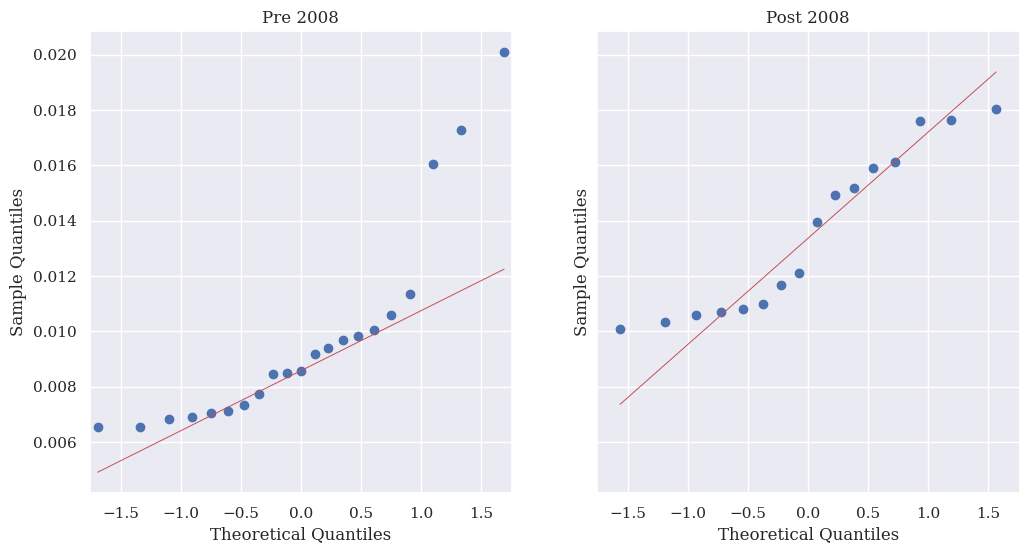

In [107]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True) 
for name, data, ax in zip(["Pre 2008", "Post 2008"], [pre_08, post_08], axs.ravel()):
    sm.qqplot(data, line='q', ax=ax);
    ax.set_title(name)
fig.savefig(charts_folder / 'combined_qq.png')

Neither of these are convincing fits, so this temporal partition does not cleanly split our data into two normally distributed subsets, and our emigration variable is not drawn from a Gaussian mixture delineated by 2008. 

## Bootstrap Comparison

Even without knowing the exact distributions of these subsets, we can investigate whether they are drawn from the same distribution numerically using a non-parametric bootstrap (Efron, 1994). This allows us to construct confidence intervals for any given statistic by the following procedure.

- A bootstrap sample is chosen by drawing from the data with replacement up to the size of the original data.
- The chosen statistic (typically a measure of central tendency, in this case the mean) is calculated on each bootstrap sample
- Quantiles are derived for the computed statistics, and we can obtain a confidence interval from this (95% by convention)

Different distributions have different moments, so if two datasets result in non-overlapping bootstrapped confidence intervals, it follows that they are drawn from different distributions, as illustrated below.

In [63]:
bootstrap_samples = 100000
pre_boot = bootstrap((pre_08.values,), np.mean, confidence_level=0.95, n_resamples=bootstrap_samples , random_state=495)
post_boot = bootstrap((post_08.values,), np.mean, confidence_level=0.95, n_resamples=bootstrap_samples , random_state=495)

print(pre_boot.confidence_interval)
print(post_boot.confidence_interval)

ConfidenceInterval(low=0.008559007428786779, high=0.011827756250822644)
ConfidenceInterval(low=0.012216990059647178, high=0.014978014114783753)


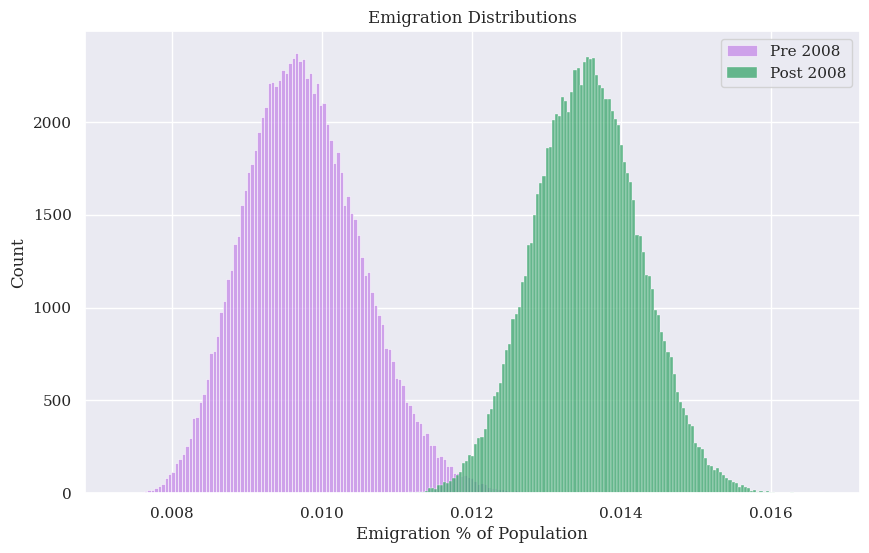

In [64]:
fig = plt.figure(figsize=(10,6))
p = sns.histplot(pre_boot.bootstrap_distribution,  color='#C589E8', label='Pre 2008')
sns.histplot(post_boot.bootstrap_distribution, color='#37a56a', label='Post 2008')
p.set_title(f"Emigration Distributions")
p.set_xlabel('Emigration % of Population')
p.legend();
fig.savefig(charts_folder / 'emigration_bootstrap_comparison.png')

We can see that the 95% confidence intervals for the means of the pre and post 2008 distributions do not overlap, so we can reject the hypothesis that the data were drawn from the same distribution, and conclude that the mean emigration rate was significantly greater post-2008.

Additionally, we can observe that the distribution of means of our bootstrap samples are normally distributed thanks to the central limit theorem, with the distribution converging to normality as the number of samples increases. This occurs even when starting with a nonnormal distribution, such as the combined pre and post '08 emigration_pop_pct variable below.

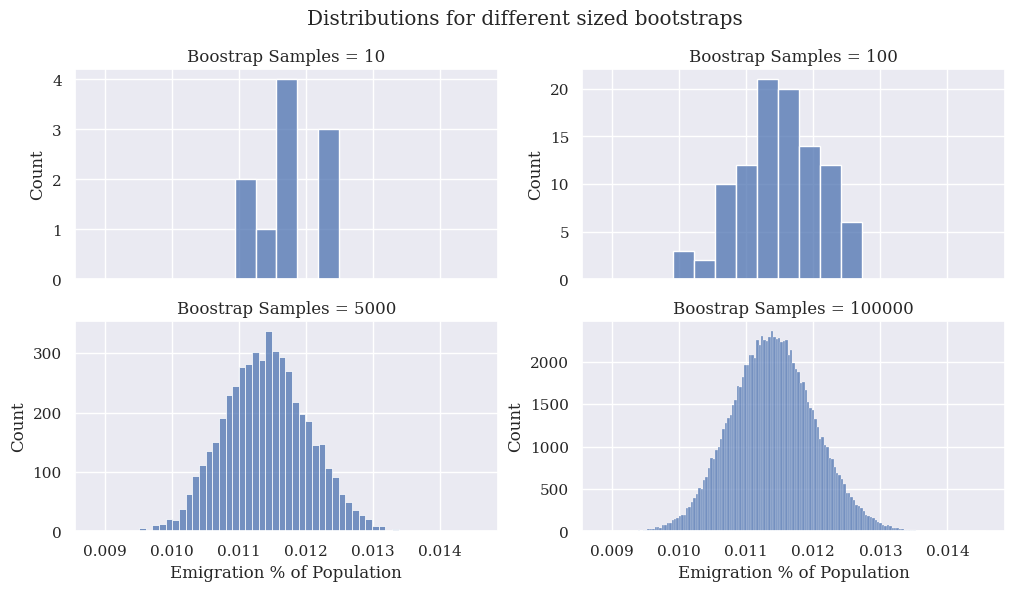

In [65]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharex=True) 
fig.suptitle("Distributions for different sized bootstraps")
bootstrap_input_data = (pop_migration_df['emigration_pop_pct'].values,)
for i, ax in zip([10, 100, 5000, 100000], axs.ravel()):
    boot = bootstrap(bootstrap_input_data, np.mean, confidence_level=0.95, n_resamples=i, random_state=495)
    data = boot.bootstrap_distribution
    sns.histplot(data, ax=ax)
    ax.set_title(f"Boostrap Samples = {i}")
    ax.set_xlabel('Emigration % of Population')
    
fig.savefig(charts_folder / 'emigration_bootstrap_vary_n.png')

# Predicting future Emigration Levels

We would like to be able to forecast emigration levels into the future based on past data. We can frame this as a supervised learning application, as we know the value of our target variable - the emigration level. In this case, as we have few features to work with, we can use the lags of our variables in addition to the variables themselves. This can be thought of as an autoregressive model, which are commonly seen in time series analysis (Chatfield, 2003) 

It is also important that when we split our data into train and test sets, we set a temporal cutoff, and don't randomly sample data points, as would be typical in generating a train/test split. If we were to randomly draw data points from the full history, data leakage could occur and the model could become informed of values in the test set based on information in the training set. This procedure of withholding the tail of a time series is commonly used in traditional forecasting applications (Bergmeir & Benitez, 2012).

We will compare multiple regression algorithms - OLS regression, linear regression with L1 and L2 regularization (Lasso & Ridge), ElasticNet, and Random Forest Regression, all available through the scikit-learn package. 

Finally, we will compare the performance of these algorithms to that of a method formulated specifically for time series data - ARIMA (Autoregressive Integrated Moving Average models), which can conveniently be tuned using the package pmdarima, which ports R's auto.arima() functionality to python.

### CRISP-DM

We are following the CRISP-DM process outlined by Wirth & Hipp (2000), which gives an iterative process for the progression of data mining projects. We have already gained an understanding of our data and done some preliminary data preparation. We will now do additional data preparation in order to frame our problem in a way compatible with the machine learning method we wish to apply, before actually applying those methods, evaluating them, and finally either deploying (or in this case accepting) the finalised model, or iterating through the previous steps in order to gain a deeper understanding and improve performance.

## Data preparation

We first want to get our independent variables into their own dataframe; the continuous variables of year, and population, migration, and emigration levels, and the categorical variables of sex and age group. We will generate lags for each of population, emigration and migration, and also generate 1 lead term for emigration to serve as our target variable. The number of lags is parameterised and will inform our train/test split criteria later, in this case 3 lag terms was selected.

As the first few years of the data don't have data in their lag terms, these come out to be null. We will ignore these rows and just deal with the rows with complete data - we could alternatively back-fill the earliest seen value, but in order to not bias the models towards older values this was not done and the rows were removed instead. 

Additionally, the last year has no lead variable for the target, as that is in the future, so these rows are discarded as well.

In [66]:
gender_age_split_migration_df = cleaned_migration_df[
    (cleaned_migration_df['age_group'] != 'All ages') & 
    (cleaned_migration_df['sex'] != 'Both sexes')
    ].pivot(columns=['inward_or_outward_flow'], index=['year', 'sex', 'age_group'], values='value').reset_index().copy()

gender_age_split_pop_df = sexes_df[sexes_df['age_group'] != 'All ages'].copy()
prediction_migration_df = gender_age_split_pop_df.rename(columns={'value': 'population'}).merge(gender_age_split_migration_df , on=['year', 'sex', 'age_group'])

features = ['year', 'age_group', 'sex', 'population', 'emigrants', 'immigrants']
prediction_migration_df = prediction_migration_df.rename(
    columns={'Emigrants: All destinations': 'emigrants', 
             'Immigrants: All origins': 'immigrants'})[features]
prediction_migration_df['population'] = prediction_migration_df['population']*1000
prediction_migration_df['emigrants'] = prediction_migration_df['emigrants']*1000
prediction_migration_df['immigrants'] = prediction_migration_df['immigrants']*1000

prediction_df = prediction_migration_df.sort_values('year', ascending=True)

num_lags = 3
for lag in range(1, num_lags+1):
    for variable in ['population', 'emigrants', 'immigrants']:
        prediction_df[f'{variable}_lag_{lag}'] = prediction_df.groupby(['age_group', 'sex'])[variable].shift(lag)

# Get the next value of emigration as our target variable
prediction_df[f'next_emigration_value'] = prediction_df.groupby(['age_group', 'sex'])['emigrants'].shift(-1)

# The first few years don't have enough lags to fill up the dataset, and the last year has no target, so we drop these
prediction_df = prediction_df.dropna(axis=0, how='any')

prediction_df.head()

,year,age_group,sex,population,emigrants,immigrants,population_lag_1,emigrants_lag_1,immigrants_lag_1,population_lag_2,emigrants_lag_2,immigrants_lag_2,population_lag_3,emigrants_lag_3,immigrants_lag_3,next_emigration_value
39,1990,65 years and over,Female,226700.0,0.0,500.0,224900.0,0.0,900.0,221800.0,0.0,500.0,218500.0,0.0,600.0,0.0
38,1990,65 years and over,Male,173300.0,0.0,800.0,172700.0,0.0,1000.0,171500.0,0.0,900.0,169700.0,0.0,500.0,0.0
37,1990,45 - 64 years,Female,303200.0,900.0,1200.0,299600.0,1500.0,1400.0,297300.0,1600.0,1000.0,295800.0,700.0,800.0,300.0
36,1990,45 - 64 years,Male,304800.0,1000.0,1500.0,300200.0,2200.0,800.0,298300.0,1600.0,1100.0,296200.0,1000.0,1000.0,100.0
35,1990,25 - 44 years,Female,477300.0,7200.0,5900.0,472600.0,8200.0,4700.0,468800.0,7300.0,3200.0,465200.0,4900.0,2700.0,4700.0


We now choose a temporal cutoff point - before this will be our training set, and after this (plus our number of lags) will be our test set. The temporal gap between the two sets ensures that none of the values of the lags of the test set are present in the training set, so no data leakage should occur. 2010 was chosen as the temporal cutoff in order to strike a balance betwen having enough training data to effectively train the models, and enough test data to effectively evaluate them. A caveat to this though is that we have previously shown that the generating process behing emigration figures changed significantly post-2008, so our training data is unfortunately not necessarily representative of our test data, however this is a necessesity given the relatively small amount of data available.

We would like to scale the population, migration, and emigration values and their lags, which we can do with a selective ColumnTransformer. We use StandardScaler to subtract the mean and divide by the standard deviation of each variable - centering and scaling the columns. This is fitted only to the training set, and the same columns in the test set are transformed using the transformations learned from the training set, again to minimise data leakage. If we applied the scalers to the whole dataset, some information about the training set would be available to the test set via the values the test set was scaled using, as the scalers would use the mean and standard deviations of both the train and test set.

We are also careful to scale our independent and dependent variables separately, as we will be using the dependent variable's scaler to perform an inverse-transform on our models predictions to get our results measured in number of people, rather than the in the scaled range. 

We also one-hot-encode the sex and age group variable, as these are encoded as strings (an argument could be made for the age group to be encoded as ordered integers instead however).

In [67]:
# Split train and test temporally with no overlap in the lags, so test set sees nothing of the training set
training_year_cutoff = 2010
train = prediction_df[prediction_df['year'] <= training_year_cutoff]
test = prediction_df[prediction_df['year'] > training_year_cutoff+num_lags]

# Column transformer to scale just numeric columns and return a pandas df
# Want to avoid scaling the year, and can't scale label columns
col_transform = ColumnTransformer(
    [
        ('X_scaler', StandardScaler(), [x for x in train.columns if x not in ['year', 'age_group', 'sex', 'next_emigration_value']]),
        ('Y_scaler', StandardScaler(), ['next_emigration_value']), # Keep this separate as it will be used for the predictions
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
).set_output(transform='pandas')

scaled_train = col_transform.fit_transform(train)
scaled_test = col_transform.transform(test)

# One hot encode after the scaler, because we don't want those columns scaled
encoded_train = pd.get_dummies(scaled_train, dtype=int)
encoded_test = pd.get_dummies(scaled_test, dtype=int)

X_train = encoded_train.drop('next_emigration_value', axis=1)
y_train = encoded_train['next_emigration_value']

X_test = encoded_test.drop('next_emigration_value', axis=1)
y_test = encoded_test['next_emigration_value']

X_train.head()

,population,emigrants,immigrants,population_lag_1,emigrants_lag_1,immigrants_lag_1,population_lag_2,emigrants_lag_2,immigrants_lag_2,population_lag_3,emigrants_lag_3,immigrants_lag_3,year,age_group_0 - 14 years,age_group_15 - 24 years,age_group_25 - 44 years,age_group_45 - 64 years,age_group_65 years and over,sex_Female,sex_Male
39,-1.247033,-0.780247,-0.812653,-1.254569,-0.790245,-0.744547,-1.275310,-0.810535,-0.781464,-1.300453,-0.805320,-0.741336,1990,0,0,0,0,1,1,0
38,-1.653882,-0.780247,-0.767975,-1.662600,-0.790245,-0.729610,-1.679206,-0.810535,-0.720469,-1.702996,-0.805320,-0.757568,1990,0,0,0,0,1,0,1
37,-0.664187,-0.591526,-0.708403,-0.670664,-0.472127,-0.669865,-0.669065,-0.457581,-0.705220,-0.662818,-0.650085,-0.708872,1990,0,0,0,1,0,1,0
36,-0.651997,-0.570557,-0.663725,-0.665974,-0.323672,-0.759483,-0.661035,-0.457581,-0.689971,-0.659518,-0.583556,-0.676408,1990,0,0,0,1,0,0,1
35,0.662264,0.729522,-0.008439,0.681622,0.948799,-0.176961,0.708036,0.799821,-0.369747,0.734536,0.281323,-0.400465,1990,0,0,1,0,0,1,0


In [68]:
# TODO: Statistics of training data - show how distribution has changed pre and post scaling
# Look at correlations between variables and target

## OLS 

When we fit a simple linear regression model, we obtain a training R^2 value of 0.96, and a test R^2 of 0.87. As The test R^2 is quite a bit less than the training R^2, this indicates that the model has not generalised as well as we would like, and is at risk of being overfit (Frost, 2020).

We also calculate the mean squared error of our model in order to compare modelling approaches later.

Train R^2 score:  0.9605
Test R^2 score:  0.8729
Test set MSE:  0.1369


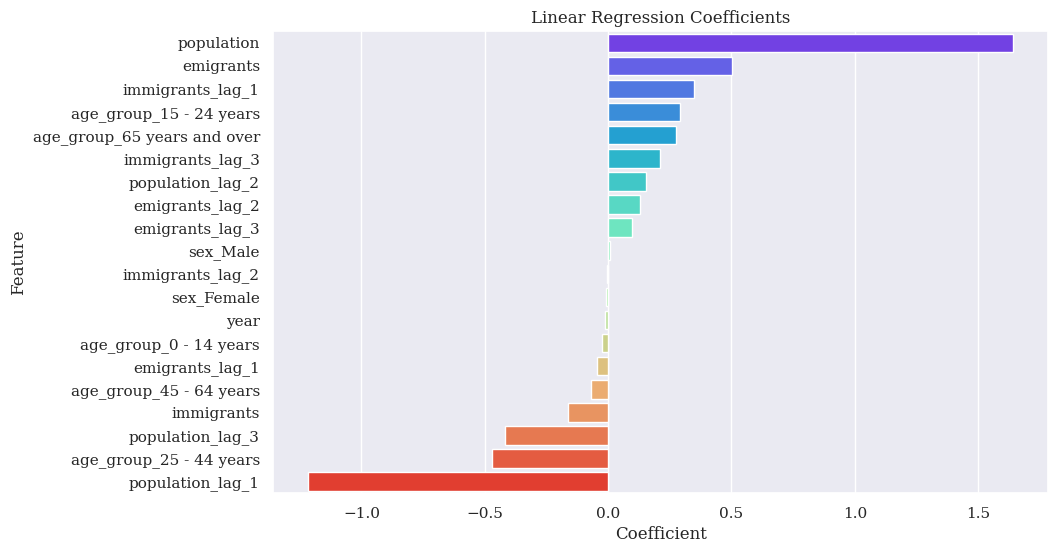

In [69]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

print(f'Train R^2 score: {regressor.score(X_train, y_train): 0.4f}')
print(f'Test R^2 score: {regressor.score(X_test, y_test): 0.4f}')

predicted = regressor.predict(X_test)
mse = np.mean((predicted - y_test)**2)
print(f"Test set MSE: {mse: 0.4f}")

coeffs = pd.Series(regressor.coef_, index=regressor.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(x=coeffs, y=coeffs.index, hue=coeffs.index, palette='rainbow')
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature');
fig.savefig(charts_folder / 'regression_features.png', bbox_inches='tight');

We can see that the features the model treats as most important (high absolute value of coefficient), are the current and previous population values, the current emigration value, the previous immigration values, and the 15-24 and 25-44 age groups. The sex varibles, year, etc. are treated as less important.

## Ridge Regression

Most of our variables have high coefficient values, so we can now look at regularization in order to reduce the complexity of our models (Burkov, 2019) - this will reduce the absolute values of the coefficients and effectively prune the features considered. 

Firstly L2, or Ridge regression. This takes a hyperparameter alpha - we will select a value for this more rigorously later using a random search cross validator, but for now we can illustrate how the R^2 score changes for various values of alpha. It appears that a value in the 10-50 range might be appropriate - this will inform the upper bound of our hyperparameter search later.

In [70]:
for i in range(1, 21, 2):
    ridge = linear_model.Ridge(alpha=i*10)
    ridge.fit(X_train, y_train)
    
    print(f'Train R^2 score, alpha = {i*10}: {ridge.score(X_train, y_train): 0.4f}')
    print(f'Test  R^2 score, alpha = {i*10}: {ridge.score(X_test, y_test): 0.4f}')
    print('---')

Train R^2 score, alpha = 10:  0.9513
Test  R^2 score, alpha = 10:  0.8259
---
Train R^2 score, alpha = 30:  0.9449
Test  R^2 score, alpha = 30:  0.8103
---
Train R^2 score, alpha = 50:  0.9408
Test  R^2 score, alpha = 50:  0.8043
---
Train R^2 score, alpha = 70:  0.9373
Test  R^2 score, alpha = 70:  0.8021
---
Train R^2 score, alpha = 90:  0.9338
Test  R^2 score, alpha = 90:  0.8018
---
Train R^2 score, alpha = 110:  0.9303
Test  R^2 score, alpha = 110:  0.8024
---
Train R^2 score, alpha = 130:  0.9266
Test  R^2 score, alpha = 130:  0.8036
---
Train R^2 score, alpha = 150:  0.9229
Test  R^2 score, alpha = 150:  0.8049
---
Train R^2 score, alpha = 170:  0.9190
Test  R^2 score, alpha = 170:  0.8063
---
Train R^2 score, alpha = 190:  0.9149
Test  R^2 score, alpha = 190:  0.8076
---


Train R^2 score:  0.9449
Test R^2 score, alpha = 30:  0.8103
Test set MSE:  0.2043


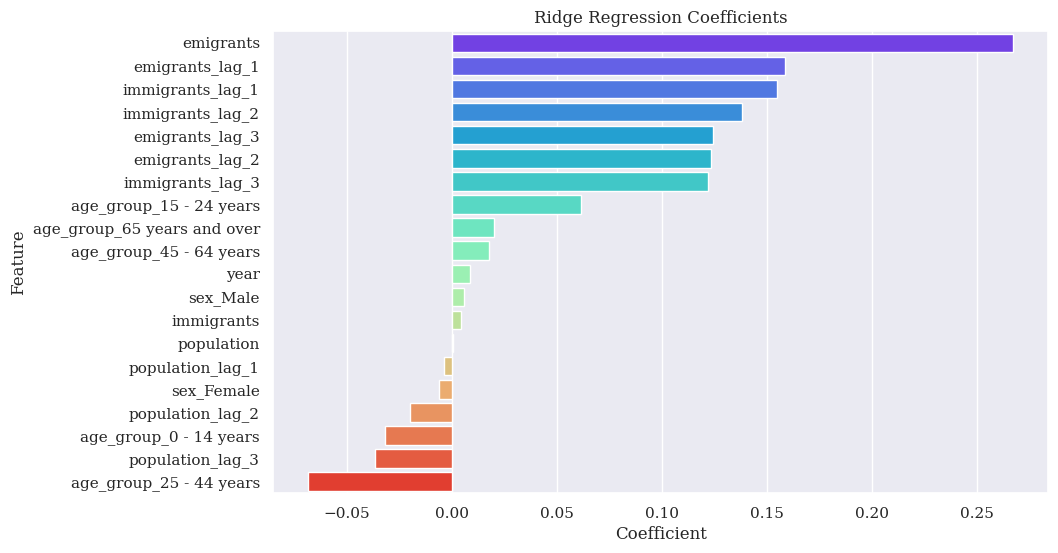

In [71]:
alpha = 30
ridge = linear_model.Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

print(f'Train R^2 score: {ridge.score(X_train, y_train): 0.4f}')
print(f'Test R^2 score, alpha = {alpha}: {ridge.score(X_test, y_test): 0.4f}')

predicted = ridge.predict(X_test)
mse = np.mean((predicted - y_test)**2)
print(f"Test set MSE: {mse: 0.4f}")

coeffs = pd.Series(ridge.coef_, index=ridge.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(x=coeffs, y=coeffs.index, hue=coeffs.index, palette='rainbow')
plt.title('Ridge Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature');
fig.savefig(charts_folder / 'regression_features_ridge.png', bbox_inches='tight')

We can see that althoguh there is still a large difference between the train and test R^2 scores, the absolute value of our coefficients have been much reduced thanks to the regularization.

## Lasso Regression

We next look at L1 regularization, or Lasso regression. This allows the absolute values of coefficients to go to zero - so in effect prunes the variables that the model uses.

We can see that lasso performs better with much lower values of alpha than we used with ridge regression. An alpha of 0.2 gives us a relatively balanced R^2 score between train and test.

In [72]:
for i in range(1, 11):
    lasso = linear_model.Lasso(alpha=1/i)
    lasso.fit(X_train, y_train)
    
    print(f'Train R^2 score, alpha = {1/i: 0.2f}: {lasso.score(X_train, y_train): 0.4f}')
    print(f'Test  R^2 score, alpha = {1/i: 0.2f}: {lasso.score(X_test, y_test): 0.4f}')
    print('---')

Train R^2 score, alpha =  1.00:  0.0145
Test  R^2 score, alpha =  1.00: -0.0743
---
Train R^2 score, alpha =  0.50:  0.6638
Test  R^2 score, alpha =  0.50:  0.6568
---
Train R^2 score, alpha =  0.33:  0.8032
Test  R^2 score, alpha =  0.33:  0.7757
---
Train R^2 score, alpha =  0.25:  0.8601
Test  R^2 score, alpha =  0.25:  0.8240
---
Train R^2 score, alpha =  0.20:  0.8885
Test  R^2 score, alpha =  0.20:  0.8474
---
Train R^2 score, alpha =  0.17:  0.9039
Test  R^2 score, alpha =  0.17:  0.8584
---
Train R^2 score, alpha =  0.14:  0.9134
Test  R^2 score, alpha =  0.14:  0.8631
---
Train R^2 score, alpha =  0.12:  0.9203
Test  R^2 score, alpha =  0.12:  0.8616
---
Train R^2 score, alpha =  0.11:  0.9250
Test  R^2 score, alpha =  0.11:  0.8589
---
Train R^2 score, alpha =  0.10:  0.9284
Test  R^2 score, alpha =  0.10:  0.8557
---


Train R^2 score:  0.8885
Test R^2 score, alpha = 0.2:  0.8474
Test set MSE:  0.1644


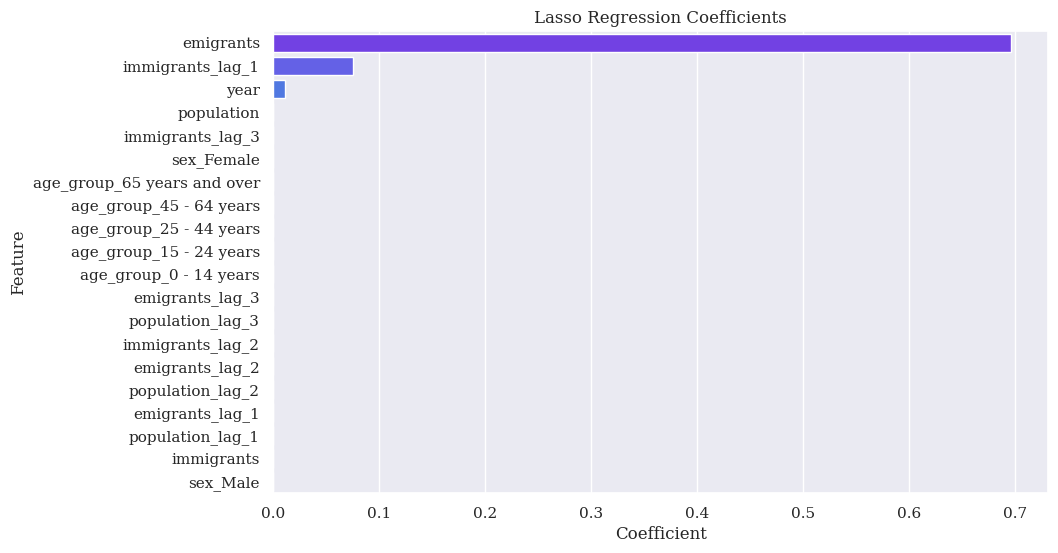

In [73]:
alpha = 0.2
lasso = linear_model.Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

print(f'Train R^2 score: {lasso.score(X_train, y_train): 0.4f}')
print(f'Test R^2 score, alpha = {alpha}: {lasso.score(X_test, y_test): 0.4f}')

predicted = lasso.predict(X_test)
mse = np.mean((predicted - y_test)**2)
print(f"Test set MSE: {mse: 0.4f}")

coeffs = pd.Series(lasso.coef_, index=lasso.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(x=coeffs, y=coeffs.index, hue=coeffs.index, palette='rainbow')
plt.title('Lasso Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature');
fig.savefig(charts_folder / 'regression_features_lasso.png', bbox_inches='tight')

We can see that the L1 regularization has allowed most of the coefficients to go to 0, and we are left with the current number of emigrants, the previous number of immigrants, and the year as variables that our model considers.

## ElasticNet Regression

Our final linear regression technique is ElasticNet, which uses a mix of L1 and L2 regularization. We can see that this achieves a balance between R^2 scores at alpha = 0.5. Again, this quick experimentation will inform our parameter search later, as we would like to avoid searching a very large hyperparameter space in order to save computation time.

In [74]:
for i in range(1, 11):
    e_net = linear_model.ElasticNet(alpha=1/i)
    e_net.fit(X_train, y_train)
    
    print(f'Train R^2 score, alpha = {1/i: 0.2f}: {e_net.score(X_train, y_train): 0.4f}')
    print(f'Test  R^2 score, alpha = {1/i: 0.2f}: {e_net.score(X_test, y_test): 0.4f}')
    print('---')

Train R^2 score, alpha =  1.00:  0.5591
Test  R^2 score, alpha =  1.00:  0.5742
---
Train R^2 score, alpha =  0.50:  0.8324
Test  R^2 score, alpha =  0.50:  0.8111
---
Train R^2 score, alpha =  0.33:  0.8899
Test  R^2 score, alpha =  0.33:  0.8309
---
Train R^2 score, alpha =  0.25:  0.9111
Test  R^2 score, alpha =  0.25:  0.8286
---
Train R^2 score, alpha =  0.20:  0.9214
Test  R^2 score, alpha =  0.20:  0.8236
---
Train R^2 score, alpha =  0.17:  0.9272
Test  R^2 score, alpha =  0.17:  0.8189
---
Train R^2 score, alpha =  0.14:  0.9309
Test  R^2 score, alpha =  0.14:  0.8150
---
Train R^2 score, alpha =  0.12:  0.9333
Test  R^2 score, alpha =  0.12:  0.8117
---
Train R^2 score, alpha =  0.11:  0.9350
Test  R^2 score, alpha =  0.11:  0.8091
---
Train R^2 score, alpha =  0.10:  0.9363
Test  R^2 score, alpha =  0.10:  0.8070
---


Train R^2 score:  0.8324
Test R^2 score, alpha = 0.5:  0.8111
Test set MSE:  0.2035


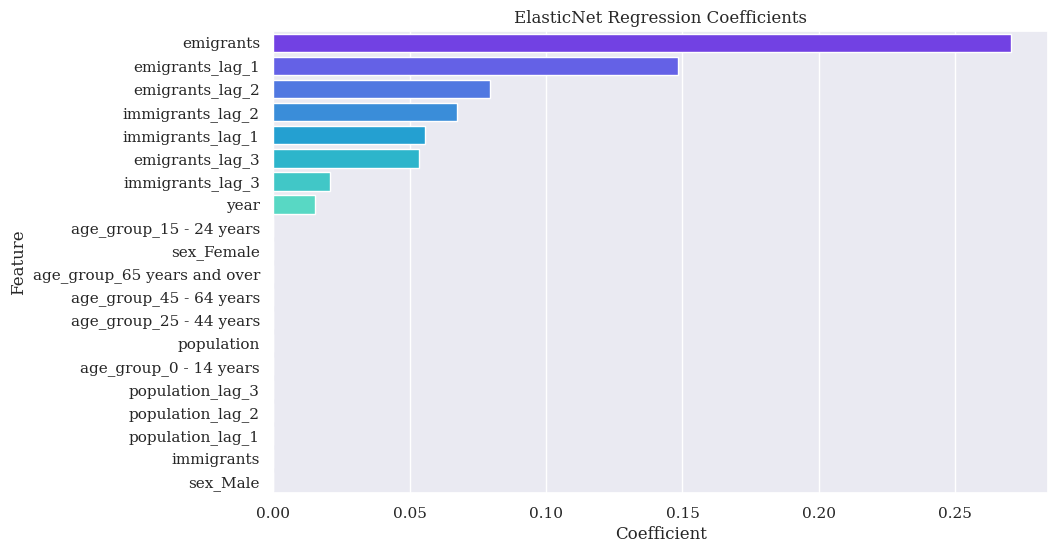

In [75]:
alpha = 0.5
e_net = linear_model.ElasticNet(alpha=alpha)
e_net.fit(X_train, y_train)

print(f'Train R^2 score: {e_net.score(X_train, y_train): 0.4f}')
print(f'Test R^2 score, alpha = {alpha}: {e_net.score(X_test, y_test): 0.4f}')

predicted = e_net.predict(X_test)
mse = np.mean((predicted - y_test)**2)
print(f"Test set MSE: {mse: 0.4f}")

coeffs = pd.Series(e_net.coef_, index=e_net.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(x=coeffs, y=coeffs.index, hue=coeffs.index, palette='rainbow')
plt.title('ElasticNet Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature');
fig.savefig(charts_folder / 'regression_features_elasticnet.png', bbox_inches='tight')

We can see that our elastic net model has not pruned the features as aggressively as Lasso, but has retained the significant features found previously via Lasso.

## Random Forest

We can also use tree-based ensemble methods for regression - in this case, Random Forest, where the predictions of many individual trees are combined to product a final estimate (Burkov, 2019).

We can also use random forest to get a sense of feature importance using the information on how much each individual tree improves with a split in each feature, averaged over each tree (Hastie et. al. 2009).

We can see that the random forest also selects the current emigration level as the most important feature.

Test set MSE:  0.2552


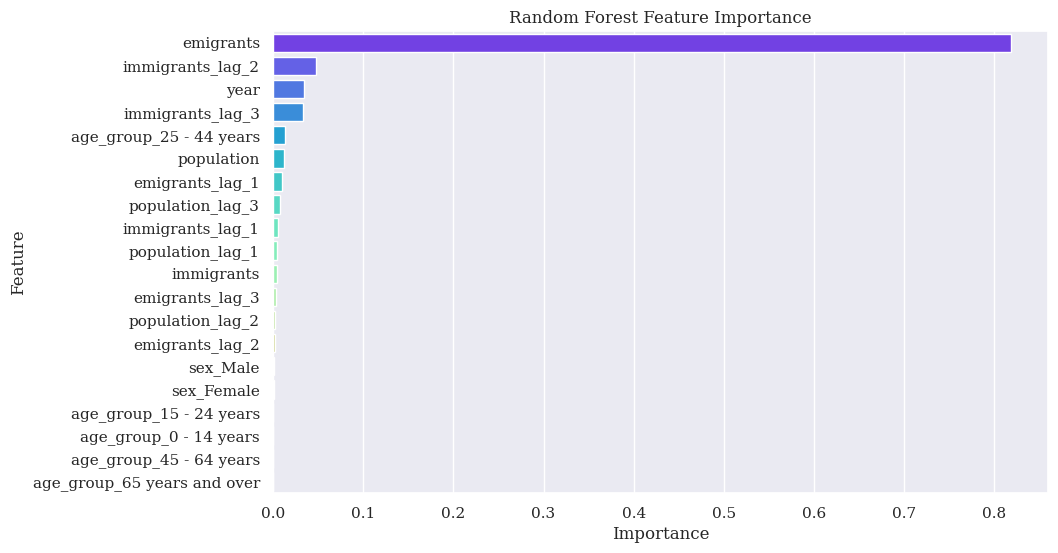

In [76]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

predicted = rf.predict(X_test)
mse = np.mean((predicted - y_test)**2)
print(f"Test set MSE: {mse: 0.4f}")

feature_imp = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(x=feature_imp, y=feature_imp.index, hue=feature_imp.index, palette='rainbow')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature');
fig.savefig(charts_folder / 'rf_importance.png', bbox_inches='tight')

## Hyperparameter Selection

We would like to be more thorough with how we select hyperparameters for each of our models. To do this, we will use two classes; RandomizedSearchCV and GridSearchCV - which fit models using many combinations of hyperparameters, score them, and provide the best model found within a given search.
They both take dictionaries with keys that correstpond to an algorithm's hyperparameters, the values of the dictionaries are different depending on the method however. 

RandomizedSearchCV takes distributions from which it randomly draws hyperparameter values (or randomly selects in the case of a list). In this case, we provide uniform distributions using the scipy library, however if we had more of an intuition of what values our parameters are likely to take, we could pass more complex arguments. GridSearchCV takes discrete values for the hyperparameters, and searches over combinations of these.

As we have done some rough experiments with the regression models above, we are able to refine our search space for their values of alpha. In the case of Random Forest, we define a grid of reasonable values to search through. Training many RandomForests is computationally intensive, especially with high numbers of very deep trees, so our grid is relatively small, but we could expand our search arbitrarily in order to further refine our model.

In [77]:
random.seed(495)

# get a uniform distribution using upper and lower bounds rather than loc and scale
def get_uniform(min, max):
    return uniform(min, max-min)
    
lasso_params = {'alpha': get_uniform(0.1, 1)}
ridge_params = {'alpha': get_uniform(5, 50)}
e_net_params = {'alpha': get_uniform(0.1, 1), 'l1_ratio': get_uniform(0.3, 0.7)}
rf_params = {'max_depth': [3, 5, 10, 20, None], 'n_estimators': [50, 100, 500], 'max_features': ['sqrt', None]}

search_iter = 30

models = {
    'OLS': linear_model.LinearRegression().fit(X_train, y_train),
    'Ridge': RandomizedSearchCV(linear_model.Ridge(), n_iter=search_iter, param_distributions=ridge_params).fit(X_train, y_train).best_estimator_,
    'Lasso': RandomizedSearchCV(linear_model.Lasso(), n_iter=search_iter, param_distributions=lasso_params).fit(X_train, y_train).best_estimator_,
    'ElasticNet': RandomizedSearchCV(linear_model.ElasticNet(), n_iter=search_iter, param_distributions=e_net_params).fit(X_train, y_train).best_estimator_,
    'RandomForest': GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=rf_params).fit(X_train, y_train).best_estimator_
}

In [78]:
print(f'Ridge alpha: {models["Ridge"].alpha}')
print(f'Lasso alpha: {models["Lasso"].alpha}')
print(f'ElasticNet alpha: {models["ElasticNet"].alpha}')

Ridge alpha: 5.716585456027717
Lasso alpha: 0.11809495731916728
ElasticNet alpha: 0.13788867664737925


## Model Selection

By taking the best estimator from each search object, we can compare the best model of each technique using their mean squared errors on the test set.

In [79]:
predictions = {}
results = {}
for name, model in models.items():
    predicted = model.predict(X_test)
    mse = np.mean((predicted - y_test)**2)
    predictions[name] = predicted
    results[name] = mse

results

{'OLS': 0.13693619246975466,
 'Ridge': 0.179633430002197,
 'Lasso': 0.150322892167757,
 'ElasticNet': 0.21999189210117345,
 'RandomForest': 0.18635289954024392}

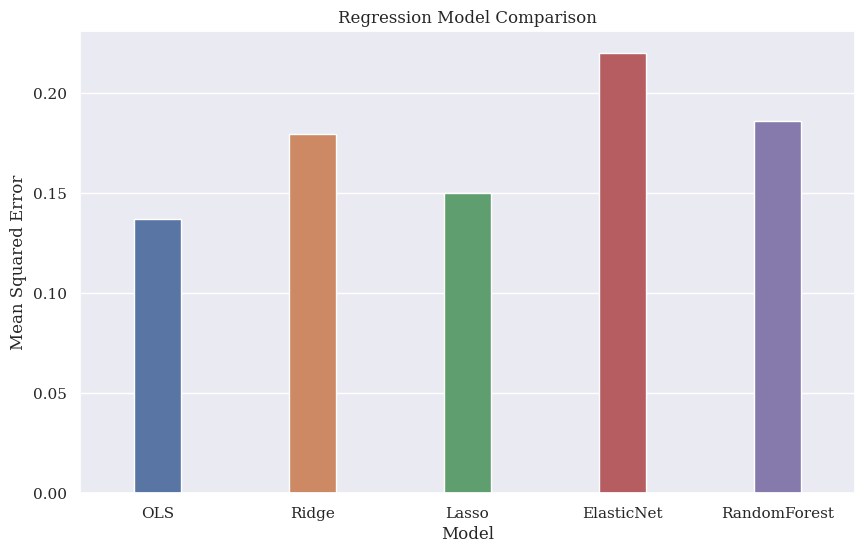

In [80]:
comparison_df = pd.DataFrame(results.items(), columns=['model', 'mse'])

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(data = comparison_df, x='model', y='mse', hue='model', width=0.3)
plt.title('Regression Model Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error');

fig.savefig(charts_folder / 'regression_comparison_mae.png')

We see that OLS performed best, with Lasso in second. By parsimony, we might elect to choose the Lasso model over the OLS model despite its worse performance as it is a simpler model due to the regularization. This balance of model complexity and predictive accuracy is not reflected in the MSE, however other measures such as the AIC (which is often used in time series analysis) do penalise model complexity. Sklearn's linear models do not have an aic value in the model outputs, so we can use the OLS implemented in the statsmodels package instead.

In [81]:

lasso_selected = [n for n, c  in zip(models['Lasso'].feature_names_in_, models['Lasso'].coef_) if abs(c) > 0]
ols_aic = sm.OLS(y_train, X_train).fit().aic
lasso_aic = sm.OLS(y_train, X_train[lasso_selected]).fit().aic
(ols_aic, lasso_aic)

(-44.78330943969354, 13.394678527403471)

Given that the ols AIC is less than the Lasso aic, we can see that although the Lasso model is simpler, the performance decrease is too great to accept this model over OLS (Burnham et. al., 2002).

In [82]:
# use the Y scaler to inverse transform the predictions
def invert_prediction(y_pred):
    y_scaler = col_transform.named_transformers_['Y_scaler']
    return y_scaler.inverse_transform(pd.DataFrame(y_pred))
    
results_df =  test[['year', 'age_group', 'sex']].copy()
results_df['ActualValue'] = invert_prediction(y_test)

for model, predicitons in predictions.items():
    results_df[f'{model}_predicted'] =  invert_prediction(predictions[model])

# prediction is for the year after the given row
results_df['year'] = results_df['year'] + 1

In [83]:
results_df.head()

,year,age_group,sex,ActualValue,OLS_predicted,Ridge_predicted,Lasso_predicted,ElasticNet_predicted,RandomForest_predicted
276,2015,45 - 64 years,Male,2900.0,1814.987737,2499.967543,2813.208103,3303.518661,1860.000000
279,2015,65 years and over,Female,700.0,1463.704102,1475.631318,2366.981530,1921.821312,835.871956
278,2015,65 years and over,Male,800.0,1264.083589,1483.860709,1886.310161,1820.173278,1173.393001
275,2015,25 - 44 years,Female,15800.0,12239.728778,14519.206684,15462.976682,15839.392820,13780.000000
277,2015,45 - 64 years,Female,1400.0,1221.085626,2034.491197,2401.773338,2962.384956,1936.000000


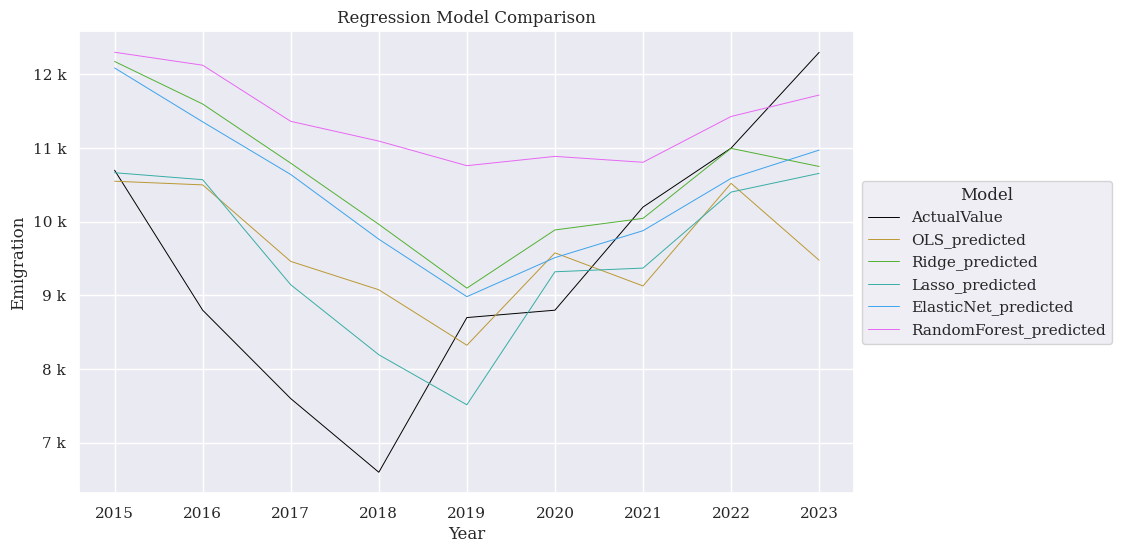

In [84]:
plot_result_df = results_df.loc[(results_df['age_group'] == '15 - 24 years') & (results_df['sex'] == 'Female')].melt(id_vars=['year', 'sex', 'age_group'])

fig, ax = plt.subplots(figsize=(10, 6)) 
var_levels = plot_result_df['variable'].unique()
cmap = sns.color_palette('husl', n_colors=len(var_levels))
palette = {k: v for k, v in zip(var_levels, cmap)}
palette['ActualValue'] = 'black'

p = sns.lineplot(plot_result_df, x = 'year', y = 'value', hue='variable', palette=palette)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(ticker.EngFormatter())
p.legend(title='Model', loc='center left', bbox_to_anchor=(1,0.5))
plt.title('Regression Model Comparison')
plt.xlabel('Year')
plt.ylabel('Emigration');
fig.savefig(charts_folder / 'regression_comparison_prediction.png')

Zooming in on a single time series - where sex is Female and age group is 15-24 - we can see that, although we have trained 5 different models using hyperparameter tuning, none of them give consistently good predictions for the next value of emigration. It appears as though each trend is vaguely following the shape of the acutal values, but offset by 1 year. This observation makes sense, as we are using lag data, and the most important variable was consistently found to be the value of the year before.

## ARIMA 
We can use a time-series specific model (ARIMA) as a comparison. In this case, we are considering the univariate time series from the above plot, and we do not need to worry about data leakage between the temporal cutoff and the test set as the ARIMA model is not using lagged variables.

In [85]:
from pmdarima.arima import AutoARIMA

arima_df =  prediction_migration_df.loc[
    (prediction_migration_df['age_group'] == '15 - 24 years') & 
    (prediction_migration_df['sex'] == 'Female'), ['year', 'emigrants']]

# We can use up to the cutoff without worrying about data leakage as this model does not use lags
arima_train = arima_df.loc[arima_df['year'] <= training_year_cutoff+num_lags]
arima_test = arima_df.loc[arima_df['year'] > training_year_cutoff+num_lags]

aa_model = AutoARIMA().fit(y=arima_train['emigrants'])
aa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -246.630
Date:                Tue, 07 Nov 2023   AIC                            499.261
Time:                        09:41:09   BIC                            503.148
Sample:                             0   HQIC                           500.417
                                 - 27                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4556.4122   2127.188      2.142      0.032     387.200    8725.625
ar.L1          0.6054      0.156      3.873      0.000       0.299       0.912
sigma2      5.132e+06      1.017   5.05e+06      0.000    5.13e+06    5.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.66   Prob(JB):                         0.25
Heteroskedasticity (H):               1.24   Skew:                             0.68
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+22. Standard errors may be unstable.
"""

We can see that auto arima has selected an AR(1), or Markov model (Chatfield, 2003), which is consistent with the results of the previous techniques - the emigration value immediately previous is the most important.

ARIMA can predict many steps ahead at once, however we can also progress one step at a time as our previous models have done. This greatly changes the predicted results; as the AR(1) model only sees its previous value, the all at once prediction stays relatively constant across the predicted years, but the one step ahead prediction matches the true values more closely - resulting in a much lower mean squared error.

In [86]:
# All at once predictions
arima_predictions = aa_model.predict(n_periods=len(arima_test))
arima_test['Arima Prediction'] = list(arima_predictions)

In [87]:
# One at a time predictions
results = []
for i in range(training_year_cutoff+num_lags+1, max(arima_df['year'])+1): 
    arima_train = arima_df.loc[arima_df['year'] <= i]
    aa_model = AutoARIMA().fit(y=arima_train['emigrants'])
    results.append(list(aa_model.predict(n_periods=1))[0])
    
arima_test['one_step_predictions'] = results

(6885058.544506227, 575945.0053570278)

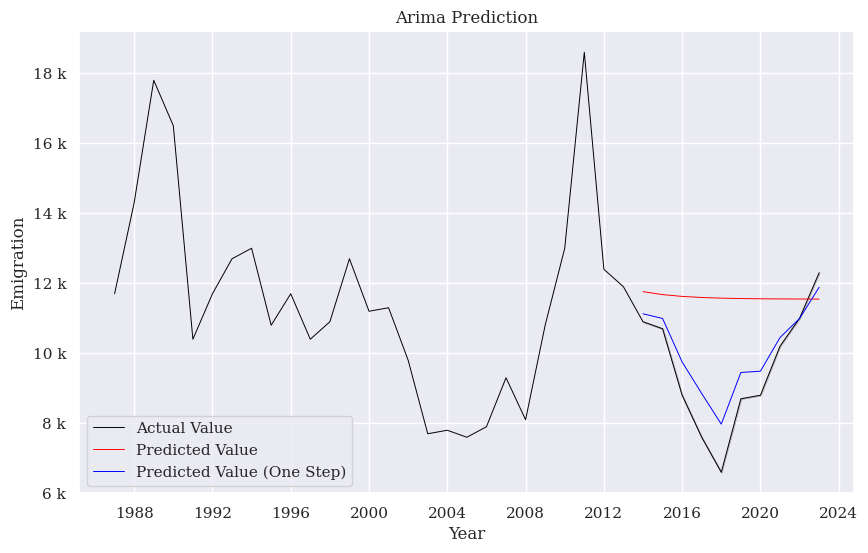

In [88]:
fig, ax = plt.subplots(figsize=(10, 6)) 

p = sns.lineplot(data=pd.concat((arima_train, arima_test), axis=0), x='year', y='emigrants', color='black', label='Actual Value')
sns.lineplot(data=arima_test, x = 'year', y = 'Arima Prediction', color='red', label='Predicted Value')
sns.lineplot(data=arima_test, x = 'year', y = 'one_step_predictions', color='blue', label='Predicted Value (One Step)')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.title('Arima Prediction')
plt.xlabel('Year')
plt.ylabel('Emigration');
fig.savefig(charts_folder / 'arima_prediction.png')


mse_total = np.mean((arima_test['Arima Prediction'] - arima_test['emigrants'])**2)
mse_one_step = np.mean((arima_test['one_step_predictions'] - arima_test['emigrants'])**2)

# TODO Inverse transform and calculate the mse for regression techniques to compare to ARIMA
(mse_total, mse_one_step)

## Iterative model building
As we have made predictions and evaluated their performance, we should go back and get a better understanding of our problem and data in order to iterate on our modelling techniques. One way we might look at this, is to think that emigration levels might be influenced by a mixture of previous emigration and immigration levels - something we're not capturing. We can use a PolynomialFeatures() transformer to capture these interaction terms and perform a polynomial regression (James et. al., 2013). We again exclude the one hot encoded terms from the transformation, and pass the interaction_only boolean so that we don't consider terms like emigration^2.

In [89]:
col_transform = ColumnTransformer(
    [
        ('X_scaler', StandardScaler(), [x for x in train.columns if x not in ['year', 'age_group', 'sex', 'next_emigration_value']]),
        ('Poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), [x for x in train.columns if x not in ['year', 'age_group', 'sex', 'next_emigration_value']]),
        ('Y_scaler', StandardScaler(), ['next_emigration_value']), # Keep this separate as it will be used for the predictions
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
).set_output(transform='pandas')

scaled_train = col_transform.fit_transform(train)
scaled_test = col_transform.transform(test)

# One hot encode after the scaler, because we don't want those columns scaled
encoded_train = pd.get_dummies(scaled_train, dtype=int)
encoded_test = pd.get_dummies(scaled_test, dtype=int)

X_train = encoded_train.drop('next_emigration_value', axis=1)
y_train = encoded_train['next_emigration_value']

X_test = encoded_test.drop('next_emigration_value', axis=1)
y_test = encoded_test['next_emigration_value']

X_train.columns

Index(['population', 'emigrants', 'immigrants', 'population_lag_1',
       'emigrants_lag_1', 'immigrants_lag_1', 'population_lag_2',
       'emigrants_lag_2', 'immigrants_lag_2', 'population_lag_3',
       'emigrants_lag_3', 'immigrants_lag_3', 'population', 'emigrants',
       'immigrants', 'population_lag_1', 'emigrants_lag_1', 'immigrants_lag_1',
       'population_lag_2', 'emigrants_lag_2', 'immigrants_lag_2',
       'population_lag_3', 'emigrants_lag_3', 'immigrants_lag_3',
       'population emigrants', 'population immigrants',
       'population population_lag_1', 'population emigrants_lag_1',
       'population immigrants_lag_1', 'population population_lag_2',
       'population emigrants_lag_2', 'population immigrants_lag_2',
       'population population_lag_3', 'population emigrants_lag_3',
       'population immigrants_lag_3', 'emigrants immigrants',
       'emigrants population_lag_1', 'emigrants emigrants_lag_1',
       'emigrants immigrants_lag_1', 'emigrants population

In [90]:
random.seed(495)

# let lasso and elasticnet take higher alpha values because there are more columns to work with
lasso_params = {'alpha': get_uniform(1, 20)}
ridge_params = {'alpha': get_uniform(5, 50)}
e_net_params = {'alpha': get_uniform(1, 20), 'l1_ratio': get_uniform(0.3, 0.7)}
rf_params = {'max_depth': [3, 5, 10, 20, None], 'n_estimators': [50, 100, 500], 'max_features': ['sqrt', None]}

search_iter = 30

models = {
    'OLS': linear_model.LinearRegression().fit(X_train, y_train),
    'Ridge': RandomizedSearchCV(linear_model.Ridge(), n_iter=search_iter, param_distributions=ridge_params).fit(X_train, y_train).best_estimator_,
    'Lasso': RandomizedSearchCV(linear_model.Lasso(), n_iter=search_iter, param_distributions=lasso_params).fit(X_train, y_train).best_estimator_,
    'ElasticNet': RandomizedSearchCV(linear_model.ElasticNet(), n_iter=search_iter, param_distributions=e_net_params).fit(X_train, y_train).best_estimator_,
    'RandomForest': GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=rf_params).fit(X_train, y_train).best_estimator_
}
predictions = {}
results = {}
for name, model in models.items():
    predicted = model.predict(X_test)
    mse = np.mean((predicted - y_test)**2)
    predictions[name] = predicted
    results[name] = mse

results

{'OLS': 0.9555289342305727,
 'Ridge': 2.562263274621275,
 'Lasso': 0.22961942070872834,
 'ElasticNet': 0.1894263956142086,
 'RandomForest': 0.16685421310765539}

We see that OLS, Lasso, and Ridge regression perform significantly worse with the new dataset. ElasticNet and Random Forest perform slightly better, however the improvement may not be considered sufficiently better to justify the aditional model complexity that our new transformer brings.

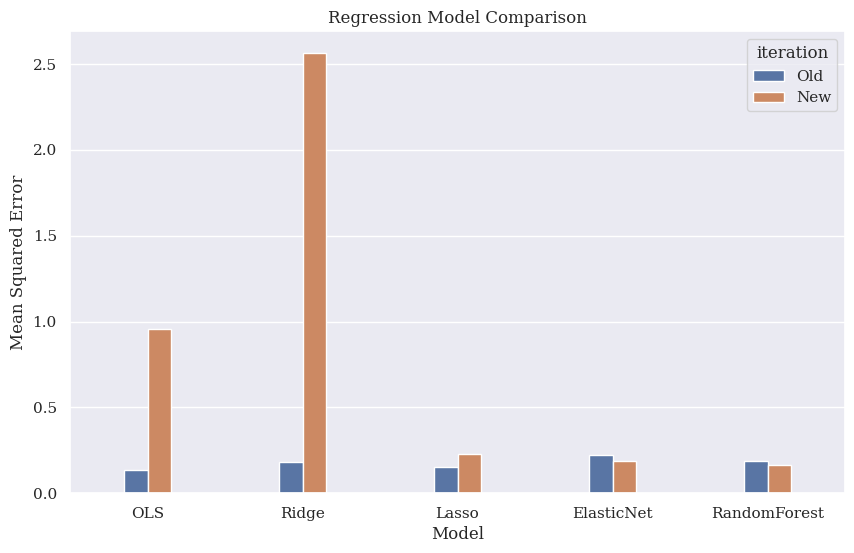

In [91]:
new_comparison_df = pd.DataFrame(results.items(), columns=['model', 'mse'])
comparison_df['iteration'] = 'Old'
new_comparison_df['iteration'] = 'New'

full_comparison_df = pd.concat([comparison_df, new_comparison_df])

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(data = full_comparison_df, x='model', y='mse', hue='iteration', width=0.3)
plt.title('Regression Model Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error');

fig.savefig(charts_folder / 'regression_comparison_mae2.png')

# Binary Classification for Predicting Emigration

In [92]:
binary_prediction_df = gender_age_split_pop_df.rename(columns={'value': 'population'}).merge(gender_age_split_migration_df , on=['year', 'sex', 'age_group'])
features = ['year', 'age_group', 'sex', 'population', 'migrants']
binary_prediction_df = binary_prediction_df.rename(
    columns={'Net migration': 'migrants'})[features]

binary_prediction_df['population'] = binary_prediction_df['population']*1000
binary_prediction_df['migrants'] = binary_prediction_df['migrants']*1000

binary_prediction_df = binary_prediction_df.sort_values('year', ascending=True)
for lag in range(1, 4):
    for variable in ['population', 'migrants']:
        binary_prediction_df[f'{variable}_lag_{lag}'] = binary_prediction_df.groupby(['age_group', 'sex'])[variable].shift(lag)

# Get the target variable
binary_prediction_df[f'next_migration_value'] = binary_prediction_df.groupby(['age_group', 'sex'])['migrants'].shift(-1)
binary_prediction_df = binary_prediction_df.dropna(axis=0, how='any')

binary_prediction_df.head()

,year,age_group,sex,population,migrants,population_lag_1,migrants_lag_1,population_lag_2,migrants_lag_2,population_lag_3,migrants_lag_3,next_migration_value
39,1990,65 years and over,Female,226700.0,500.0,224900.0,900.0,221800.0,500.0,218500.0,600.0,800.0
38,1990,65 years and over,Male,173300.0,800.0,172700.0,1000.0,171500.0,900.0,169700.0,500.0,900.0
37,1990,45 - 64 years,Female,303200.0,300.0,299600.0,-100.0,297300.0,-600.0,295800.0,100.0,800.0
36,1990,45 - 64 years,Male,304800.0,500.0,300200.0,-1400.0,298300.0,-500.0,296200.0,0.0,1300.0
35,1990,25 - 44 years,Female,477300.0,-1300.0,472600.0,-3500.0,468800.0,-4100.0,465200.0,-2200.0,1800.0


In [93]:
bin_train = binary_prediction_df[binary_prediction_df['year'] <= training_year_cutoff]
bin_test = binary_prediction_df[binary_prediction_df['year'] > training_year_cutoff+num_lags]

col_transform = ColumnTransformer(
    [
        ('X_scaler', StandardScaler(), [x for x in bin_train.columns if x not in ['year', 'age_group', 'sex', 'next_migration_value']])
    ], 
    remainder='passthrough', 
    verbose_feature_names_out=False
).set_output(transform='pandas')

bin_scaled_train = col_transform.fit_transform(bin_train)
bin_scaled_test = col_transform.transform(bin_test)

# One hot encode after the scaler, because we don't want those columns scaled
bin_encoded_train = pd.get_dummies(bin_scaled_train, dtype=int)
bin_encoded_test = pd.get_dummies(bin_scaled_test, dtype=int)

# Prediction task is whether net migration will be positive or negative
bin_X_train = bin_encoded_train.drop('next_migration_value', axis=1)
bin_y_train = [['Negative Net Migration', 'Positive Net Migration'][x] for x in bin_encoded_train['next_migration_value'] > 0]

bin_X_test = bin_encoded_test.drop('next_migration_value', axis=1)
bin_y_test = [['Negative Net Migration', 'Positive Net Migration'][x] for x in bin_encoded_test['next_migration_value'] > 0]

In [94]:
logistic_params = {'C': get_uniform(0.005, 10), 'penalty': ['l1', 'l2', 'elasticnet']}
tree_params = {'max_depth': [3, 5, 10, None], 'max_features': ['sqrt', None]}
rf_params = {'max_depth': [3, 5, 10, None], 'n_estimators': [50, 100, 500], 'max_features': ['sqrt', None]}

models = {
    "Logistic Regression": RandomizedSearchCV(linear_model.LogisticRegression(), param_distributions=logistic_params).fit(bin_X_train, bin_y_train).best_estimator_,
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(), param_grid=tree_params).fit(bin_X_train, bin_y_train).best_estimator_,
    'Random Forest': GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid=rf_params).fit(bin_X_train, bin_y_train).best_estimator_
}

In [95]:
predictions = {}
results = {}
for name, model in models.items():
    predicted = model.predict(bin_X_test)
    accuracy = accuracy_score(bin_y_test, predicted)
    predictions[name] = predicted
    results[name] = accuracy

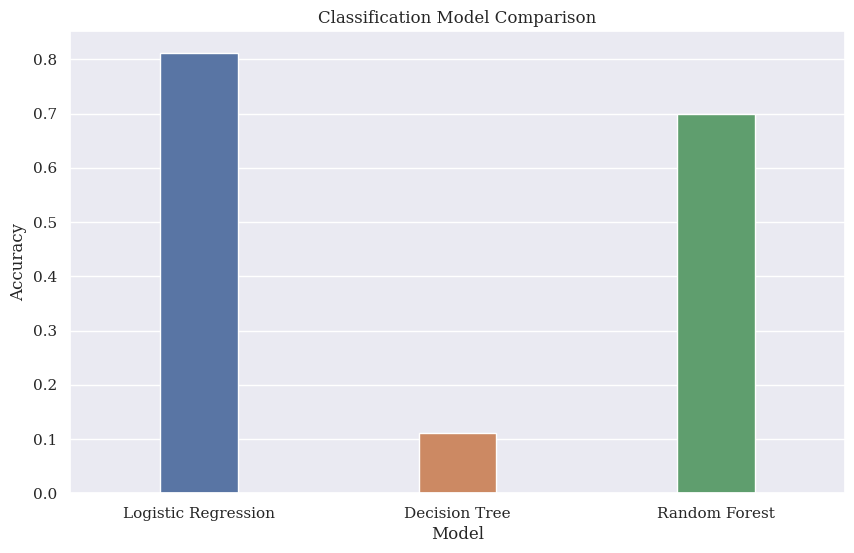

In [96]:
comparison_df = pd.DataFrame(results.items(), columns=['model', 'accuracy'])

fig, ax = plt.subplots(figsize=(10, 6)) 
p = sns.barplot(data = comparison_df, x='model', y='accuracy', hue='model', width=0.3)
plt.title('Classification Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy');

fig.savefig(charts_folder / 'classification_comparison_acc.png')

Logistic Regression


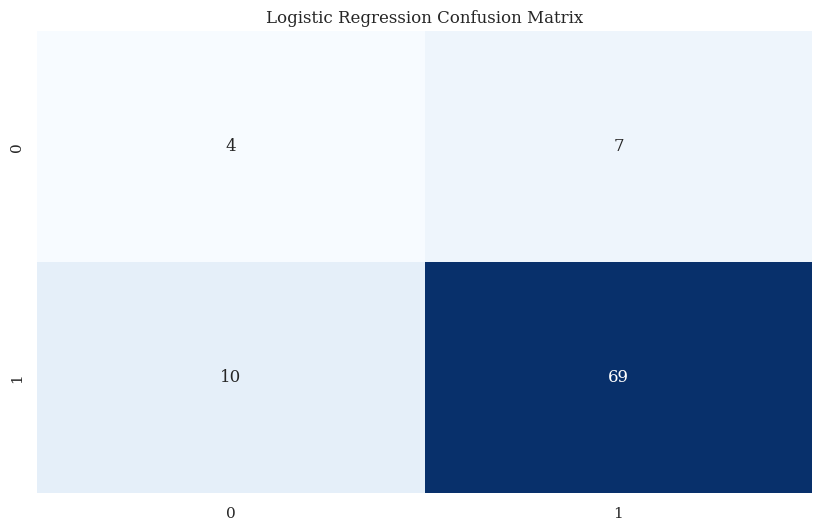

                        precision    recall  f1-score   support

Negative Net Migration       0.29      0.36      0.32        11
Positive Net Migration       0.91      0.87      0.89        79

              accuracy                           0.81        90
             macro avg       0.60      0.62      0.61        90
          weighted avg       0.83      0.81      0.82        90

Decision Tree


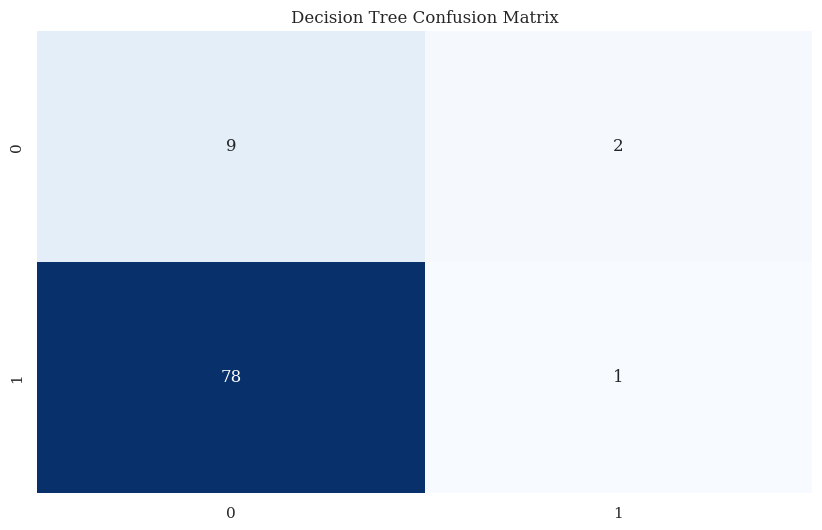

                        precision    recall  f1-score   support

Negative Net Migration       0.10      0.82      0.18        11
Positive Net Migration       0.33      0.01      0.02        79

              accuracy                           0.11        90
             macro avg       0.22      0.42      0.10        90
          weighted avg       0.31      0.11      0.04        90

Random Forest


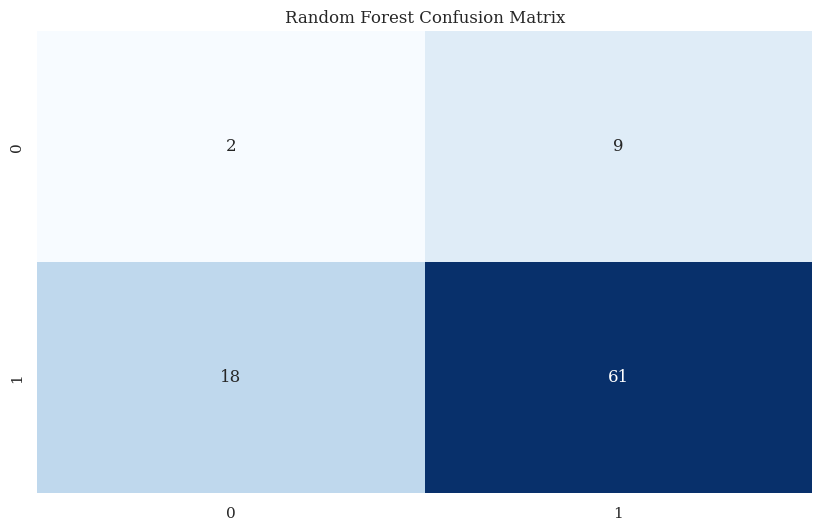

                        precision    recall  f1-score   support

Negative Net Migration       0.10      0.18      0.13        11
Positive Net Migration       0.87      0.77      0.82        79

              accuracy                           0.70        90
             macro avg       0.49      0.48      0.47        90
          weighted avg       0.78      0.70      0.73        90



In [97]:
for name, model in models.items():
    print(name)
    prediction = models[name].predict(bin_X_test)
    cm = confusion_matrix(bin_y_test, prediction)
    fig, ax = plt.subplots(figsize=(10, 6)) 
    p = sns.heatmap(cm, annot = True, cmap='Blues', cbar=False)
    plt.title(f'{name} Confusion Matrix')
    fig.savefig(charts_folder / f'confusion_matrix_{name}.png')
    plt.show();
    print(classification_report(bin_y_test, prediction))
    
    # TODO: Get the class labels on the confusion matrix

# References


- Bergmeir, C., Benítez, J.M., 2012. On the use of cross-validation for time series predictor evaluation. Information Sciences 191, 192–213. https://doi.org/10.1016/j.ins.2011.12.028
- Burkov, A., 2019. The hundred-page machine learning book. Andriy Burkov, Polen.
- Burnham, K.P., Anderson, D.R., Burnham, K.P., 2002. Model selection and multimodel inference: a practical information-theoretic approach, 2nd ed. ed. Springer, New York.
- Chatfield, C., 2003. The Analysis of Time Series, 0 ed. Chapman and Hall/CRC. https://doi.org/10.4324/9780203491683
- CSO, n.d. 2016 Census.
- Efron, B., Tibshirani, R.J., 1994. An Introduction to the Bootstrap, 0 ed. Chapman and Hall/CRC. https://doi.org/10.1201/9780429246593
- Frost, Jim, 2020. Regression Analysis: An Intuitive Guide for Using and Interpreting Linear Models.
- Gryclewska, B., 2016. Why women live longer than men? Review of biological and non-biological factors. Przeglad lekarski 73, 392–394.
- Hastie, T., Tibshirani, R., Friedman, J.H., 2017. The elements of statistical learning: data mining, inference, and prediction, Second edition, corrected at 12th printing 2017. ed, Springer series in statistics. Springer, New York, NY. https://doi.org/10.1007/b94608
- James, G., Witten, D., Hastie, T., Tibshirani, R., 2013. An Introduction to Statistical Learning, Springer Texts in Statistics. Springer New York, New York, NY. https://doi.org/10.1007/978-1-4614-7138-7
- Martin, R.C., 2012. Clean code: a handbook of agile software craftsmanship, Repr. ed, Robert C. Martin series. Prentice Hall, Upper Saddle River, NJ Munich.
- Mckinney, W., 2010. Data structures for statistical computing in python. Proceedings of the 9th Python in Science Conference.
- Moritz, S., Sardá, A., Bartz-Beielstein, T., Zaefferer, M., Stork, J., 2015. Comparison of different Methods for Univariate Time Series Imputation in R.
- Nichol, D., n.d. Coloring for Colorblindness.
- Tufte, E., 2001. The visual display of quantitative information / E.R. tufte. American Journal of Physics 31. https://doi.org/10.1109/MPER.1988.587534
- Weiss, N.A., 2017. Introductory statistics, 10th edition, global edition. ed. Pearson, Boston; Columbus; Indianapolis New York.
- Wickham, H., 2014. Tidy Data. J. Stat. Soft. 59. https://doi.org/10.18637/jss.v059.i10
- Wilson, T., 2016. Visualising the demographic factors which shape population age structure. Demographic Research 35, 867–890.
- Wirth, R., Hipp, J., 2000. Crisp-dm: towards a standard process modell for data mining.
- Yee, J.L., Niemeier, D.A., 1996. Advantages and disadvantages : longitudinal vs. repeated cross-section surveys.